*Muestro más abajo las descripciones de cada columna:*

- ***Age***: Age of the patient (years)
- ***Sex***: Sex of the patient (M: Male, F: Female)
- ***ChestPainType***: Chest pain type (TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic)
- ***RestingBP***: Resting blood pressure (mm Hg)
- ***Cholesterol***: Serum cholesterol (mm/dl)
- ***FastingBS***: Fasting blood sugar (1: if FastingBS > 120 mg/dl, 0: otherwise)
- ***RestingECG***: Resting electrocardiogram results (Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria)
- ***MaxHR***: Maximum heart rate achieved (Numeric value between 60 and 202)
- ***ExerciseAngina***:  Exercise-induced angina (Y: Yes, N: No)
- ***Oldpeak***: Oldpeak = ST (Numeric value measured in depression)
- ***ST_Slope***: The slope of the peak exercise ST segment (Up: upsloping, Flat: flat, Down: downsloping)
- ***HeartDisease***: Output class (1: heart disease, 0: Normal)

In [1]:
# Importamos las librerías

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mannwhitneyu
from scipy import stats
from scipy.stats import chi2_contingency

In [2]:
# Función para pintas la variables categóricas

def pinta_distribucion_categoricas(df, columnas_categoricas, relativa=False, mostrar_valores=False):
    num_columnas = len(columnas_categoricas)
    num_filas = (num_columnas // 2) + (num_columnas % 2)

    fig, axes = plt.subplots(num_filas, 2, figsize=(15, 5 * num_filas))
    axes = axes.flatten() 

    for i, col in enumerate(columnas_categoricas):
        ax = axes[i]
        if relativa:
            total = df[col].value_counts().sum()
            serie = df[col].value_counts().apply(lambda x: x / total)
            sns.barplot(x=serie.index, y=serie, ax=ax, palette='viridis', hue = serie.index, legend = False)
            ax.set_ylabel('Frecuencia Relativa')
        else:
            serie = df[col].value_counts()
            sns.barplot(x=serie.index, y=serie, ax=ax, palette='viridis', hue = serie.index, legend = False)
            ax.set_ylabel('Frecuencia')

        ax.set_title(f'Distribución de {col}')
        ax.set_xlabel('')
        ax.tick_params(axis='x', rotation=45)

        if mostrar_valores:
            for p in ax.patches:
                height = p.get_height()
                ax.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height), 
                            ha='center', va='center', xytext=(0, 9), textcoords='offset points')

    for j in range(i + 1, num_filas * 2):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [3]:
# Función para pintar varios diagramas boxplot

def plot_multiple_boxplots(df, columns):
    num_cols = 3
    num_rows = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 3 * num_rows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        if df[column].dtype in ['int64', 'float64']:
            sns.boxplot(data=df, x=column, ax=axes[i])
            axes[i].set_title(column)

    # Ocultar ejes vacíos
    for j in range(i+1, num_rows * 2):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [4]:
# Abrimos el archivo csv en un dataset

df = pd.read_csv("../data/heart.csv")

## EXPLORACIÓN INICIAL

In [5]:
# Visualizamos el dataframe

pd.set_option("display.max_columns", None) # Así vemos todas las columnas
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [6]:
# Vamos a ver los valores únicos de las diferentes columnas a ver si hay algo raro

for columna in df.columns:
    print(f"{columna}: {df[columna].sort_values().unique()}")
    print("--------------")

Age: [28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77]
--------------
Sex: ['F' 'M']
--------------
ChestPainType: ['ASY' 'ATA' 'NAP' 'TA']
--------------
RestingBP: [  0  80  92  94  95  96  98 100 101 102 104 105 106 108 110 112 113 114
 115 116 117 118 120 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 148 150 152 154 155 156
 158 160 164 165 170 172 174 178 180 185 190 192 200]
--------------
Cholesterol: [  0  85 100 110 113 117 123 126 129 131 132 139 141 142 147 149 152 153
 156 157 159 160 161 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184 185 186 187 188 190 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213
 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247

*Me da que tenemos un valor raro en RestingBP = 0*

In [7]:
# Vemos la descripción general matemática de los valores numéricos

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


*En principio se deja entre ver que para las 7 variables numéricas mostradas arriba no hay valores nulos*

In [8]:
# Vemos información más completa de las variables

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


*Efectivamente, se ratifica que no hay valores nulos en ninguna de las columnas*

In [9]:
# Comprobamos si hay valores duplicados

df.duplicated(keep = False).value_counts()

False    918
Name: count, dtype: int64

*Tampoco hay valores duplicados*

In [10]:
# Comprobamos si hay valores nulos

df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

*Tampoco hay valores nulos*

## ANÁLISIS

In [11]:
 # Función para determinar la cardinalidad

def card_tipo(df, umbral_categoria = 10, umbral_continua = 30):
    # Primera parte: Preparo el dataset con cardinalidades, % variación cardinalidad, y tipos
    df_temp = pd.DataFrame([df.nunique(), df.nunique()/len(df) * 100, df.dtypes]) # Cardinaliad y porcentaje de variación de cardinalidad
    df_temp = df_temp.T # Como nos da los valores de las columnas en columnas, y quiero que estas sean filas, la traspongo
    df_temp = df_temp.rename(columns = {0: "Card", 1: "%_Card", 2: "Tipo"}) # Cambio el nombre de la transposición anterior para que tengan más sentido, y uso asignación en vez de inplace = True (esto es arbitrario para el tamaño de este dataset)

    # Corrección para cuando solo tengo un valor
    df_temp.loc[df_temp.Card == 1, "%_Card"] = 0.00

    # Creo la columna de sugerencia de tipo de variable, empiezo considerando todas categóricas pero podría haber empezado por cualquiera, siempre que adapte los filtros siguientes de forma correspondiente
    df_temp["tipo_sugerido"] = "Categorica"
    df_temp.loc[df_temp["Card"] == 2, "tipo_sugerido"] = "Binaria"
    df_temp.loc[df_temp["Card"] >= umbral_categoria, "tipo_sugerido"] = "Numerica discreta"
    df_temp.loc[df_temp["%_Card"] >= umbral_continua, "tipo_sugerido"] = "Numerica continua"

    return df_temp

In [12]:
card_tipo(df)

,Card,%_Card,Tipo,tipo_sugerido
Age,50,5.446623,int64,Numerica discreta
Sex,2,0.217865,object,Binaria
ChestPainType,4,0.43573,object,Categorica
RestingBP,67,7.298475,int64,Numerica discreta
Cholesterol,222,24.183007,int64,Numerica discreta
FastingBS,2,0.217865,int64,Binaria
RestingECG,3,0.326797,object,Categorica
MaxHR,119,12.962963,int64,Numerica discreta
ExerciseAngina,2,0.217865,object,Binaria
Oldpeak,53,5.77342,float64,Numerica discreta


Completamos todo lo que sepamos de los datos:

|Columna/variable| Descripción| Tipo de variable| Importancia inicial| Notas|
|-|-|-|-|-|
|Age| Age of the patient (years)| Numérica discreta| 0|
|Sex| Sex of the patient (M: Male, F: Female)| Binaria| 0|
|ChestPainType| Chest pain type (TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic)| Categórica nominal| 0| 
|RestingBP| Resting blood pressure (mm Hg)| Numérica discreta| 0|
|Cholesterol| Serum cholesterol (mm/dl)| Numérica discreta| 0| 
|FastingBS| Fasting blood sugar (1: if FastingBS > 120 mg/dl, 0: otherwise)| Binaria| 0|
|RestingECG| Resting electrocardiogram results (Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria)| Categórica nominal| 1|
|MaxHR| Maximum heart rate achieved (Numeric value between 60 and 202)| Numérica discreta| 0| 
|ExerciseAngina| Exercise-induced angina (Y: Yes, N: No)| Binaria| 0| 
|Oldpeak| Oldpeak = ST (Numeric value measured in depression)| Numérica discreta| 2|
|ST_Slope| The slope of the peak exercise ST segment (Up: upsloping, Flat: flat, Down: downsloping)| Categórica nominal| 2|
|HeartDisease| Output class (1: heart disease, 0: Normal)| Binaria| 0|

In [13]:
# Definimos dos listas: una para las variables númericas y otra para las categóricas

cols_numericas = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak", ]

cols_categoricas_nominales = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope", "HeartDisease"]

### ANÁLISIS UNIVARIANTE

#### TENDENCIA CENTRAL

In [14]:
# Obtenemos la media de las columnas numéricas

for i in cols_numericas:
    print(f"{i}: {df[i].describe().loc["mean"]}")

Age: 53.510893246187365
RestingBP: 132.39651416122004
Cholesterol: 198.7995642701525
MaxHR: 136.80936819172112
Oldpeak: 0.8873638344226579


In [15]:
# Obtenemos la mediana de las columnas numéricas

for i in cols_numericas:
    print(f"{i}: {df[i].describe().loc["50%"]}")

Age: 54.0
RestingBP: 130.0
Cholesterol: 223.0
MaxHR: 138.0
Oldpeak: 0.6


In [16]:
# Obtenemos la moda de las columnas categóricas nominales

df[cols_categoricas_nominales].mode().T

,0
Sex,M
ChestPainType,ASY
FastingBS,0
RestingECG,Normal
ExerciseAngina,N
ST_Slope,Flat
HeartDisease,1


*En primer lugar se observa que las medias y las medianas de las variables "Age", "RestingBP", "MaxHR" y "Oldpeak" son muy similares, por lo que se podría indicar que los datos son bastante simétricos.* \
*Sin embargo, en la variable "Cholesterol" la media y mediana diferen más, por lo que los datos no son simétricos*
*Además:*
- *La edad de la población está en torno a 53-54 años*
- *La presión arterial en reposo está en torno a 130-132*
- *El colesterol está, en un valor medio de 198, mientras que el 50% de la muestra (mediana) está en 223*
- *Las pulsaciones máximas están en torno a 137*
- *Y el índice utilizado en medida de la depresión está en 0.6-0.8*

*Finalmente:*
- *El sexo que más aparece es "Male"*
- *La mayoría de la muestra es asintomática*
- *El azúcar en sangre en ayunas está por debajo de 120*
- *El electrocardiograma en reposo es normal*
- *No hay angina inducida por el ejercicio*
- *La pendiente del segmento ST del ejercicio máximo es plano*
- *La mayoría han padecido enfermedad cardíaca*

#### FRECUENCIAS

##### ABSOLUTA

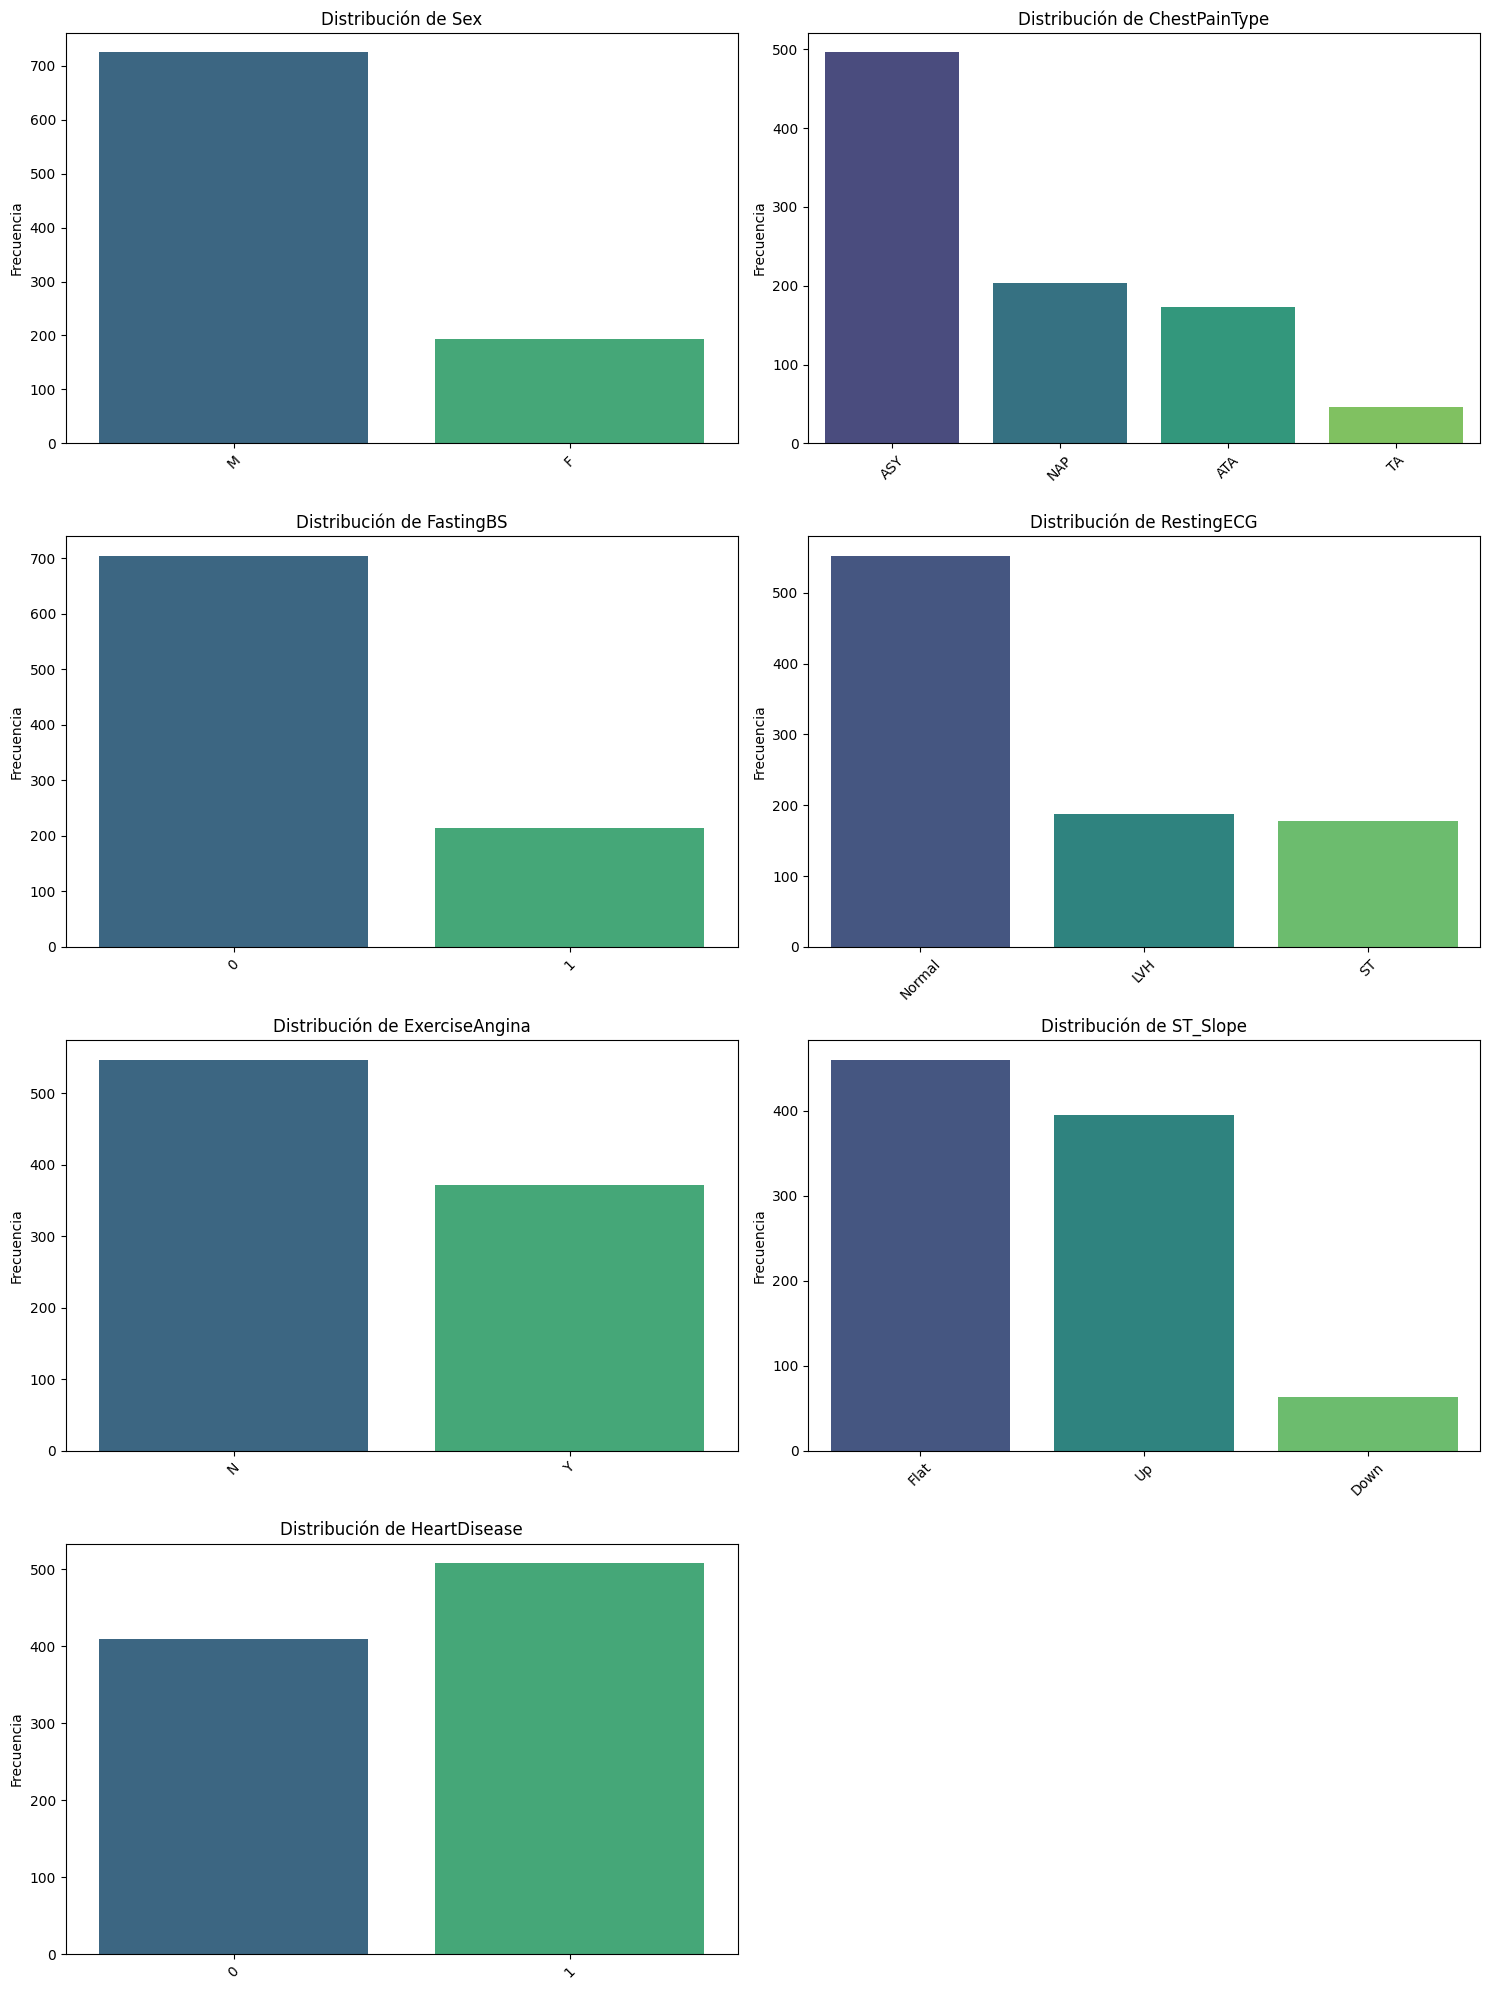

In [17]:
pinta_distribucion_categoricas(df, cols_categoricas_nominales)

##### RELATIVA

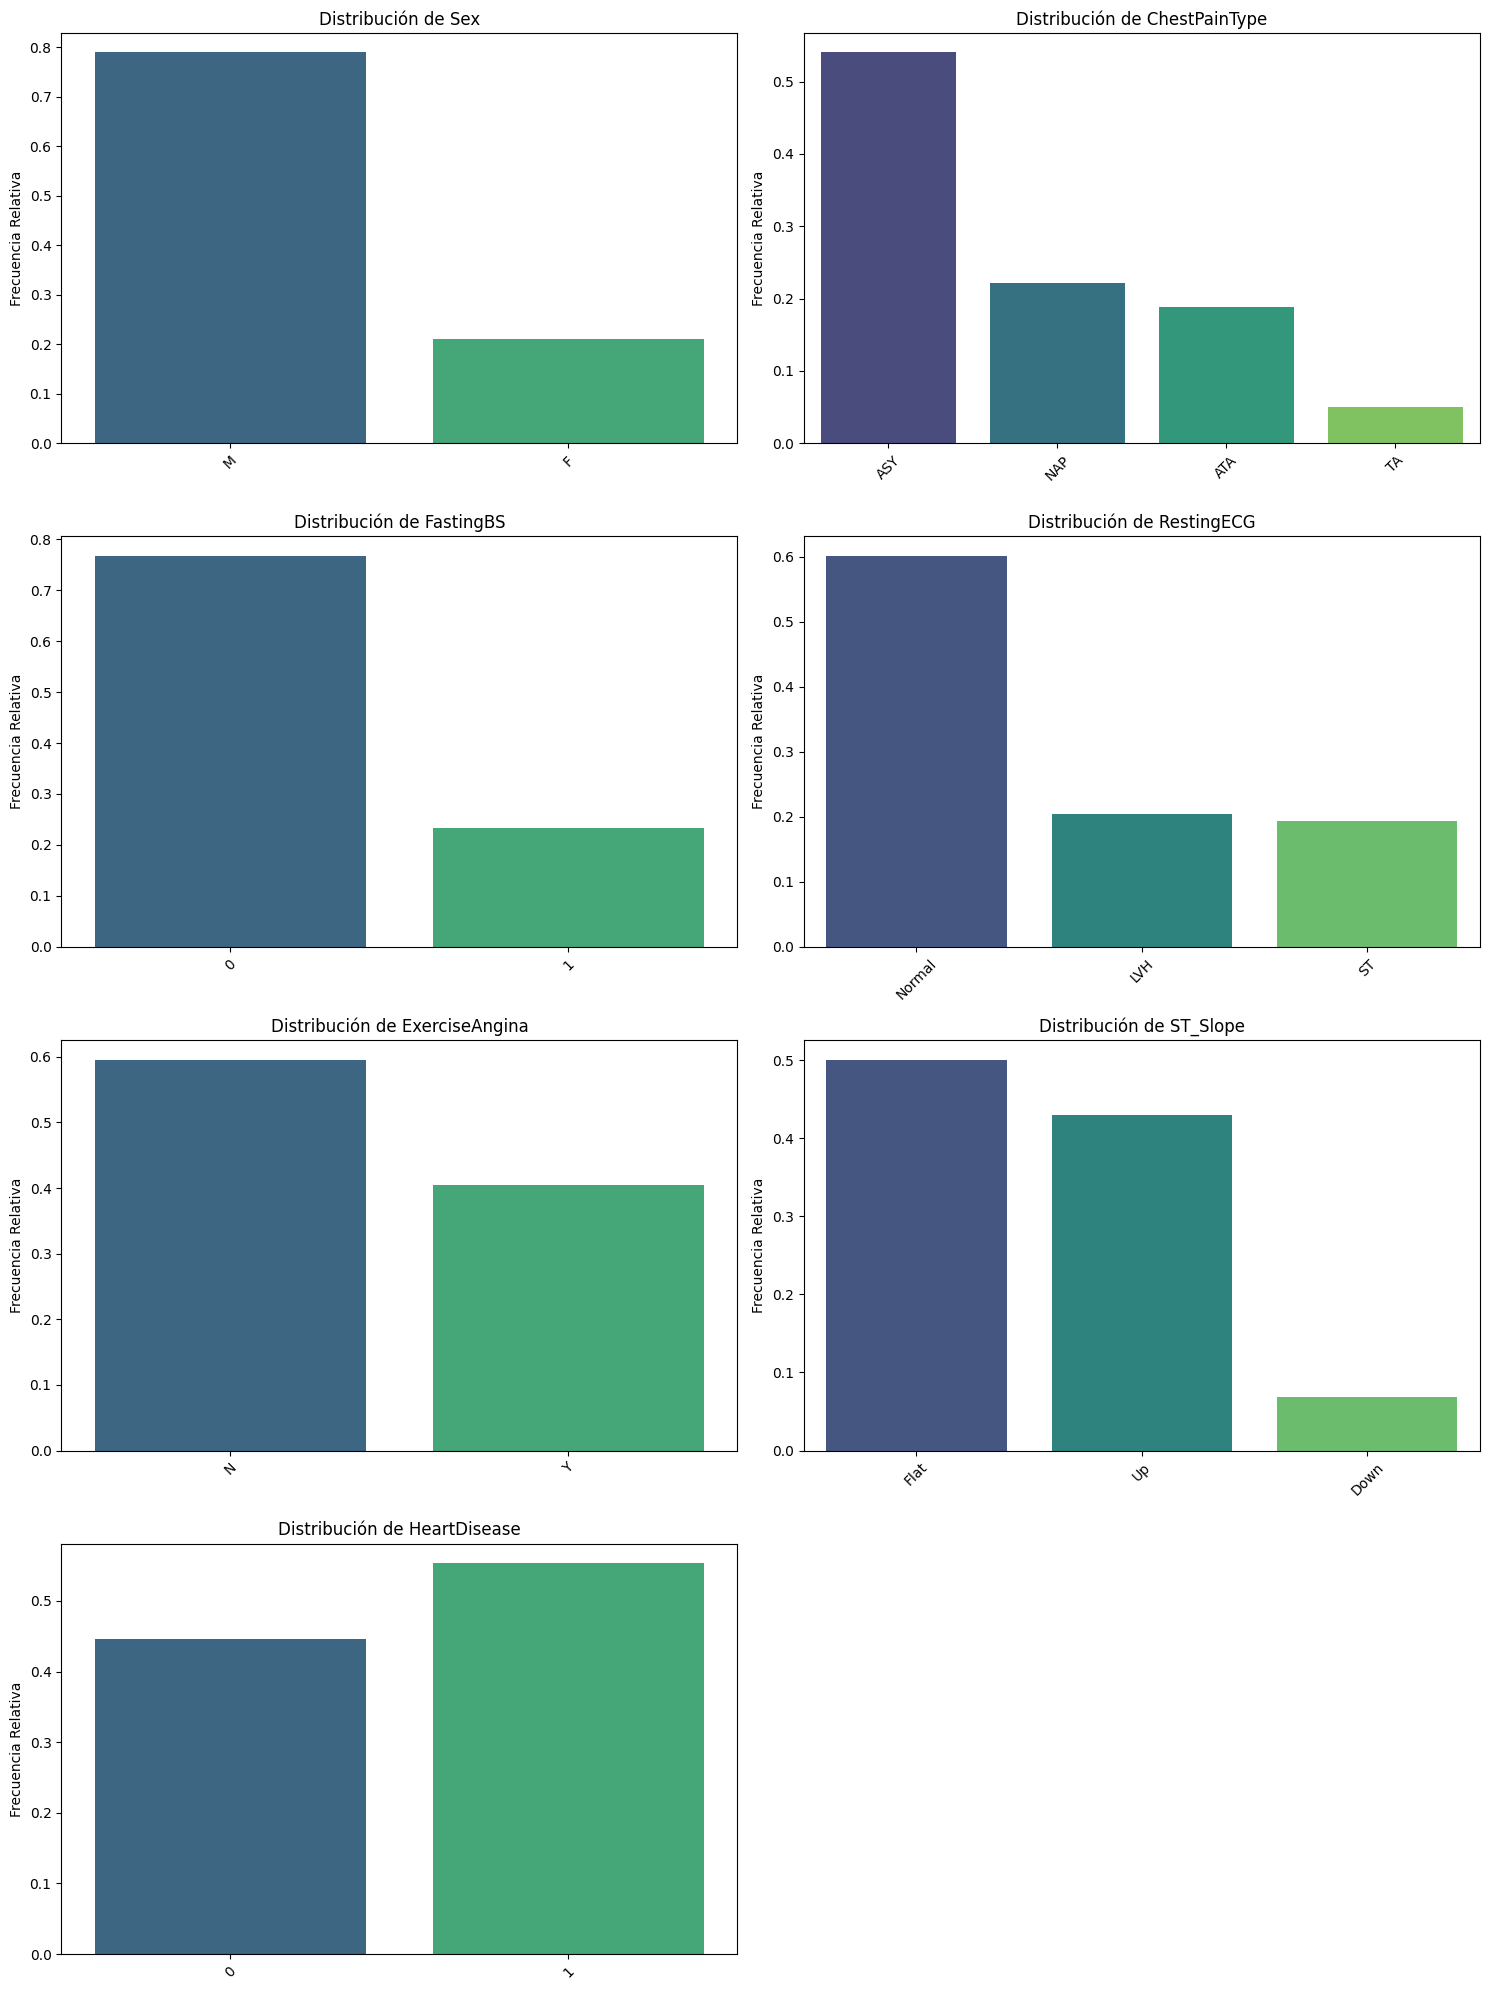

In [18]:
pinta_distribucion_categoricas(df, cols_categoricas_nominales, relativa=True)

*Temas:*

- *La proporción de hombres es mayor que de mujeres*
- *La proporción de asintomáticos es bastante importante*
- *El azúcar en sangre en ayunas por debajo de 120 prevalece por mucho*
- *ECG en reposo es normal en la gran cantidad de los casos*
- *Prevalece que no haya angina inducida por el ejercicio*
- *La pendiente ST está repartida principamente entre plano y alto*
- *Las afecciones están repartidas*

#### MEDIDAS DE POSICIÓN

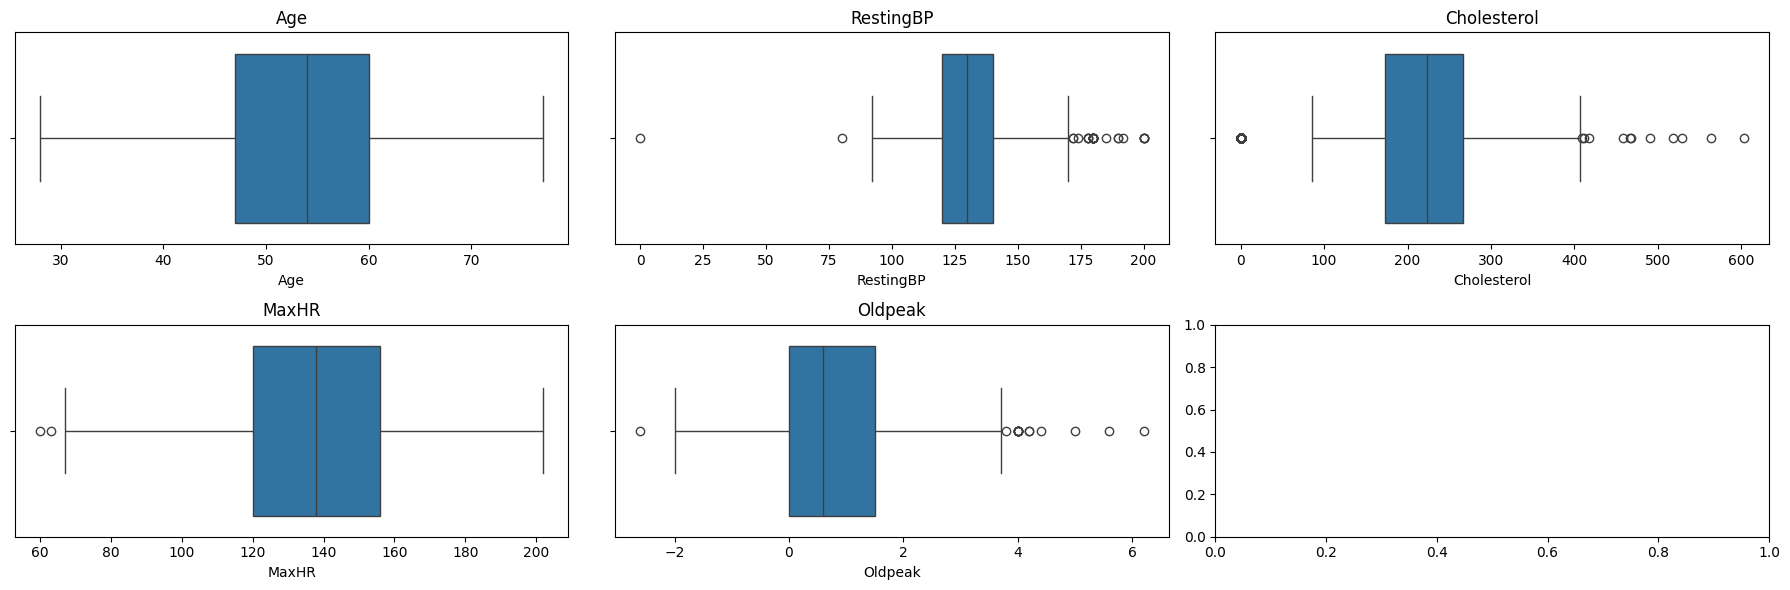

In [19]:
plot_multiple_boxplots(df, cols_numericas)

In [20]:
for columna in cols_numericas:
    IQR = df[columna].describe().loc["75%"] - df[columna].describe().loc["25%"]
    rango = df[columna].describe().loc["max"] - df[columna].describe().loc["min"]
    IQR_porcentaje = (IQR/rango) * 100
    print(f"IQR de {columna}: {IQR_porcentaje}")

IQR de Age: 26.53061224489796
IQR de RestingBP: 10.0
IQR de Cholesterol: 15.547263681592039
IQR de MaxHR: 25.352112676056336
IQR de Oldpeak: 17.045454545454543


In [64]:
def encontrar_outliers(df):
    
    dict_outliers = {}

    for columna in cols_numericas:

        valores = []

        Q1 = df[columna].describe().loc["25%"]
        Q3 = df[columna].describe().loc["75%"]

        IQR = Q3 - Q1   

        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        for i in df[columna]:
            if i < limite_inferior or i > limite_superior:
                valores.append(i)

        dict_outliers[columna] = valores 

    return dict_outliers

In [73]:
dict_outliers = encontrar_outliers(df)

In [105]:
for clave, valor in dict_outliers.items():
    print(f"Columna: {clave}") 
    print(f"Outliers: {sorted(valor)}")
    print(f"Cantidad outliers: {len(valor)}")
    print(f"Outliers únicos: {sorted(list(set(valor)))}")
    print(f"Cantidad de outliers únicos: {len(list(set(valor)))}\n")
    print("---------------")

Columna: Age
Outliers: []
Cantidad outliers: 0
Outliers únicos: []
Cantidad de outliers únicos: 0

---------------
Columna: RestingBP
Outliers: [0, 80, 172, 172, 174, 178, 178, 178, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 185, 190, 190, 192, 200, 200, 200, 200]
Cantidad outliers: 28
Outliers únicos: [0, 80, 172, 174, 178, 180, 185, 190, 192, 200]
Cantidad de outliers únicos: 10

---------------
Columna: Cholesterol
Outliers: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 409, 412, 417, 458, 466, 468, 491,

*Temas:*

- *Se aprecian outliers en todas las variables menos "Age"*
- *En la mayoría de casos se ve cierta simetría de los datos dentro del rango intercuartílico (las cajas a cada lado de la mediana son bastante similares). Donde menos se aprecia sería en "Oldpeak*
- *"Age", "MaxHR" y "Oldpeak" tienen unos bigotes más largos por lo que sugiere mayor dispersión de los valores*

#### DISTRIBUCIÓN

*Vamos a sacar los histogramas y las funciones de densidad de probabilidad*

In [21]:
# Vamos a utilizar la función de abajo para obtener el histograma y la función de densidad de probabilidad

def plot_histo_den(df, columns):
    num_cols = len(columns)
    num_rows = num_cols // 2 + num_cols % 2
    fig, axes = plt.subplots(num_rows, 2, figsize=(12, 6 * num_rows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        if df[column].dtype in ['int64', 'float64']:
            sns.histplot(df[column], kde=True, ax=axes[i])
            axes[i].set_title(f'Histograma y KDE de {column}')

    # Ocultar ejes vacíos
    for j in range(i + 1, num_rows * 2):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

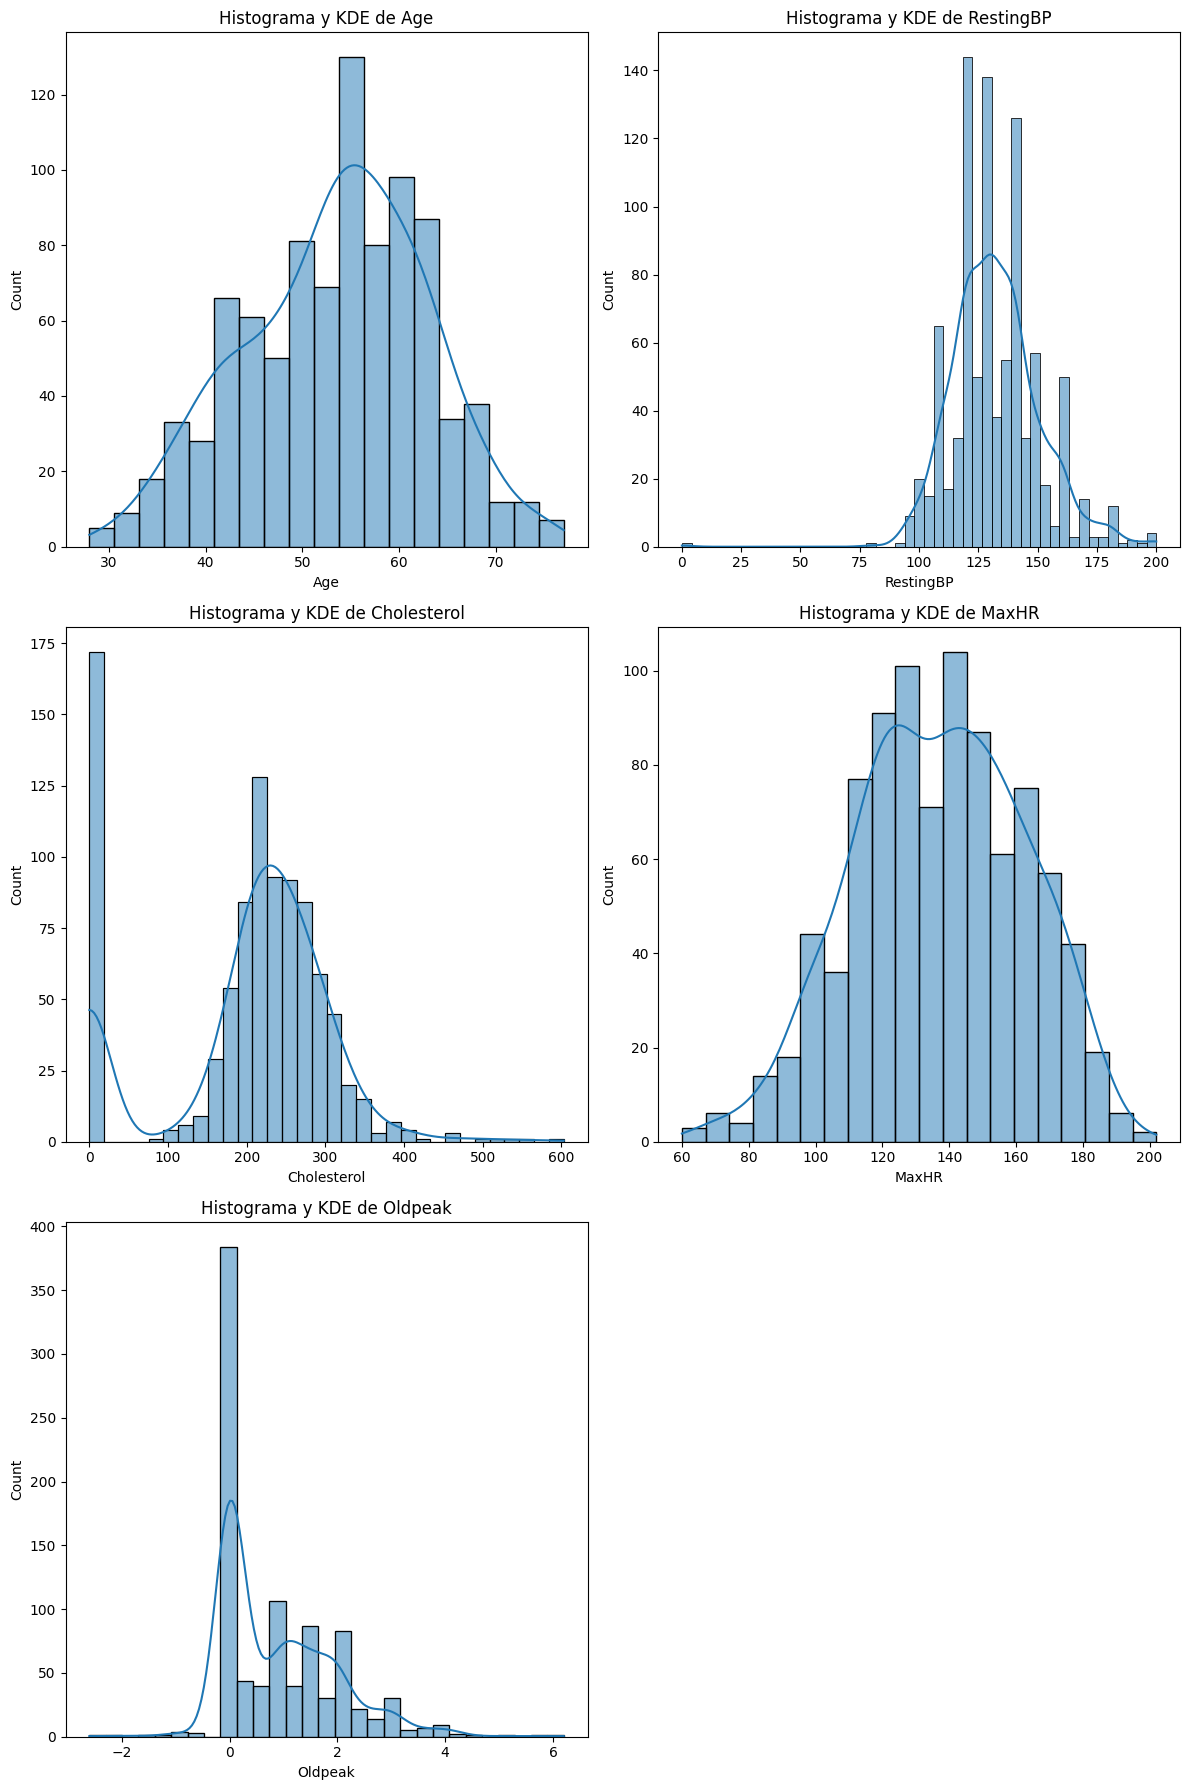

In [22]:
plot_histo_den(df, cols_numericas)

*Vamos a sacar ahora el histograma/función de densidad de probabilidad junto con los boxplot para ver los outliers también*

In [23]:
def plot_combined_graphs(df, columns, whisker_width=1.5, bins = None):
    num_cols = len(columns)
    if num_cols:
        
        fig, axes = plt.subplots(num_cols, 2, figsize=(12, 5 * num_cols))
        print(axes.shape)

        for i, column in enumerate(columns):
            if df[column].dtype in ['int64', 'float64']:
                # Histograma y KDE
                sns.histplot(df[column], kde=True, ax=axes[i,0] if num_cols > 1 else axes[0], bins= "auto" if not bins else bins)
                if num_cols > 1:
                    axes[i,0].set_title(f'Histograma y KDE de {column}')
                else:
                    axes[0].set_title(f'Histograma y KDE de {column}')

                # Boxplot
                sns.boxplot(x=df[column], ax=axes[i,1] if num_cols > 1 else axes[1], whis=whisker_width)
                if num_cols > 1:
                    axes[i,1].set_title(f'Boxplot de {column}')
                else:
                    axes[1].set_title(f'Boxplot de {column}')

        plt.tight_layout()
        plt.show()

(5, 2)


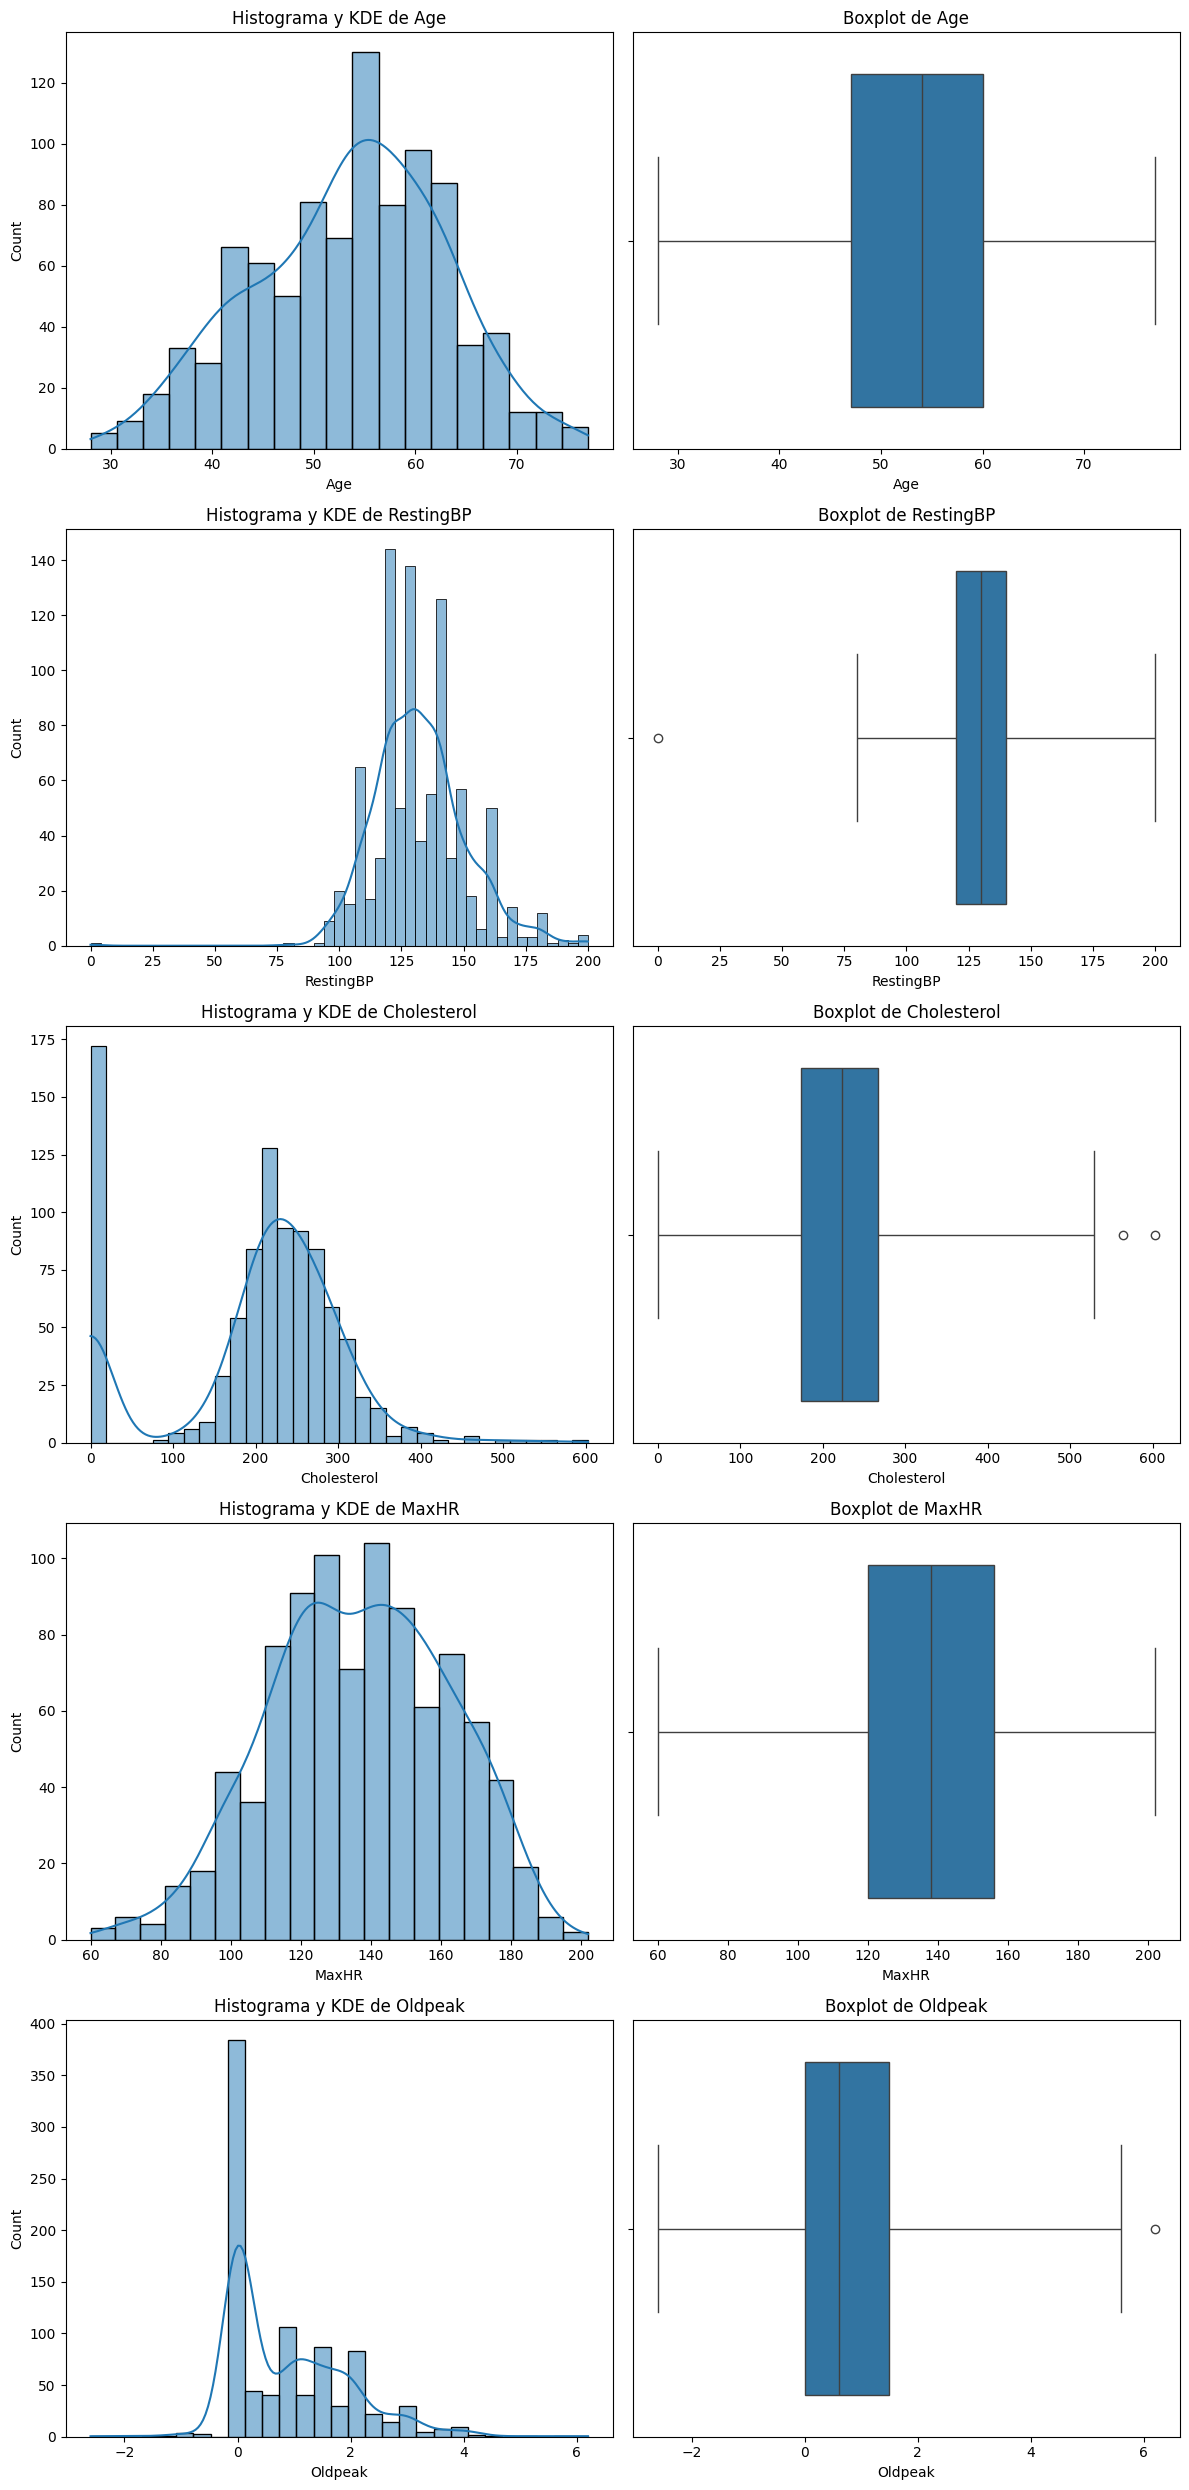

In [24]:
plot_combined_graphs(df, columns = cols_numericas, whisker_width=3)

In [25]:
df_cholesterol_0 = df[df["Cholesterol"] == 0]
df_cholesterol_0

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


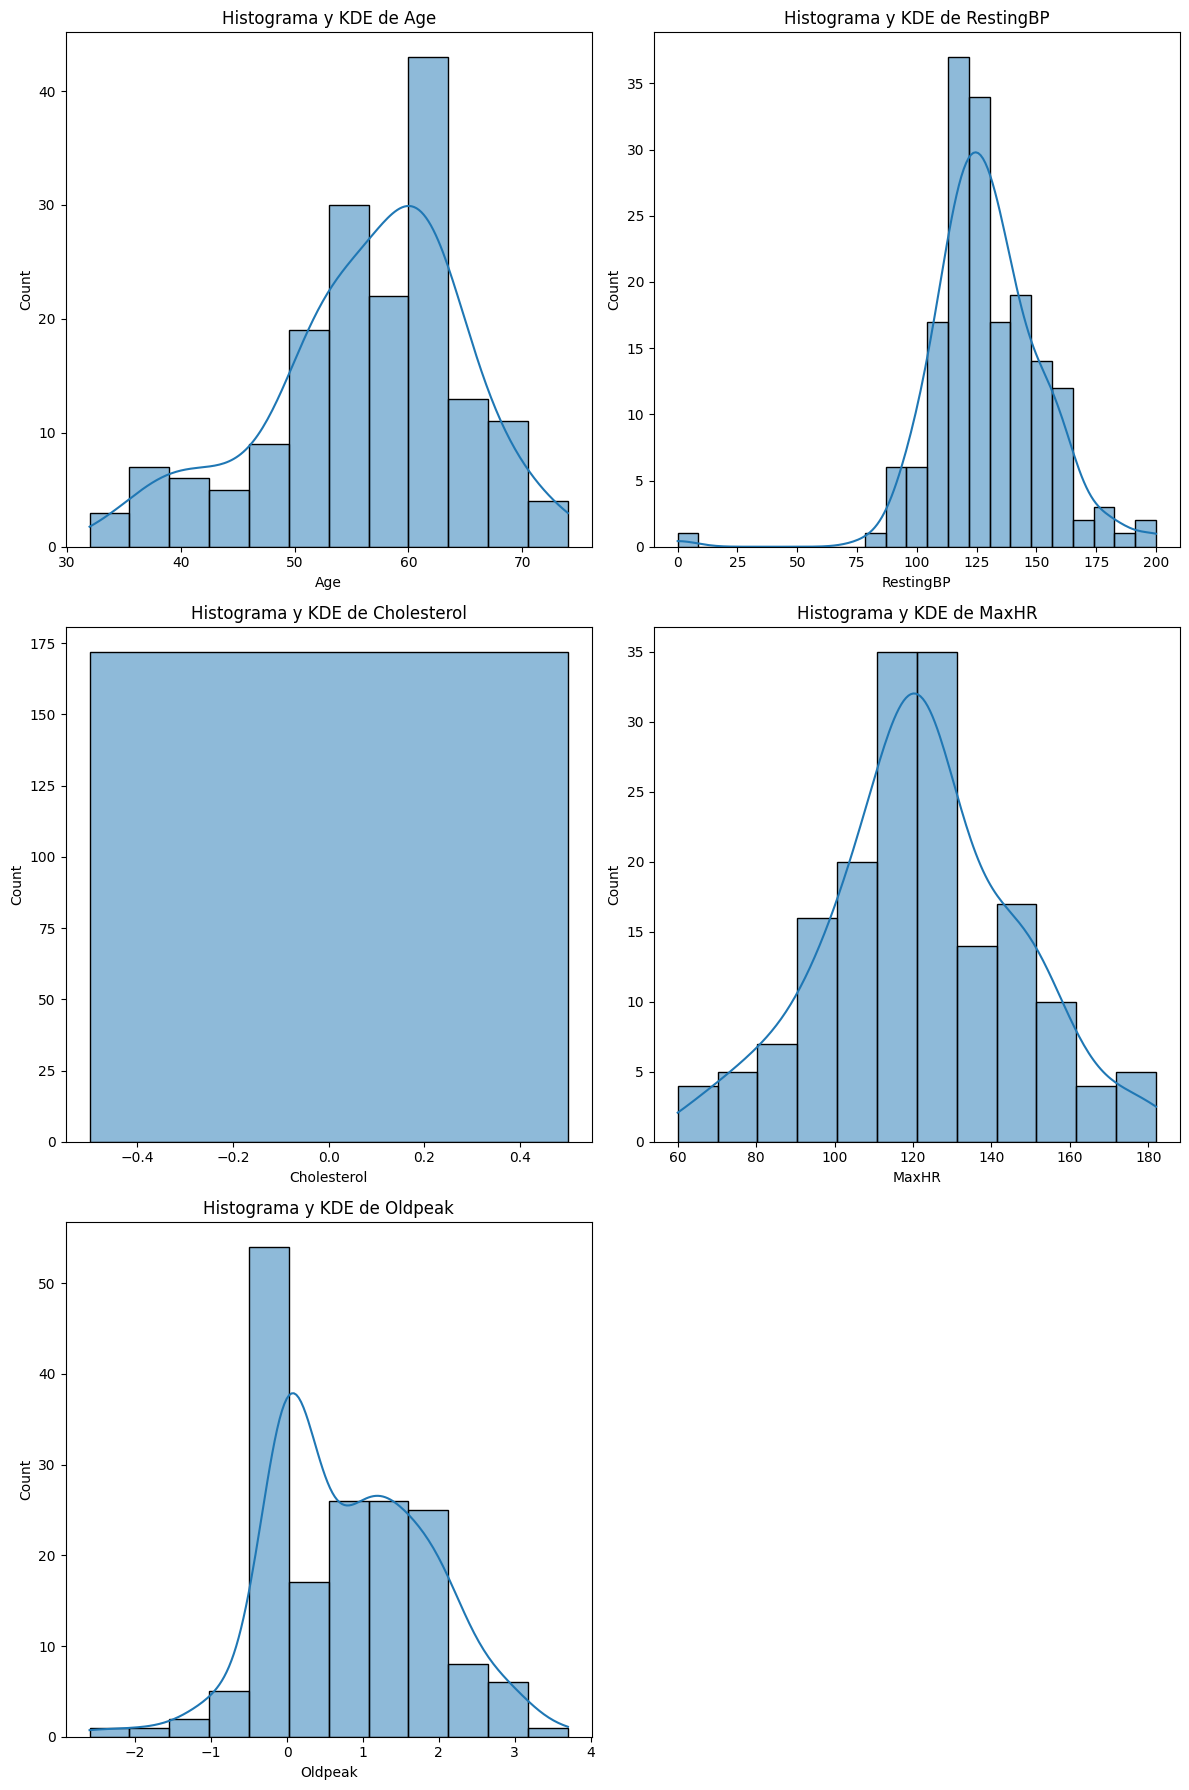

In [26]:
plot_histo_den(df_cholesterol_0, cols_numericas)

### ANÁLISIS BIVARIANTE

#### CATEGÓRICAS

In [27]:
# Función para hacer análisis bivariante de categóricas

def plot_categorical_relationship_fin(df, cat_col1, cat_col2, relative_freq=False, show_values=False, size_group = 10):
    # Prepara los datos
    count_data = df.groupby([cat_col1, cat_col2]).size().reset_index(name='count')
    total_counts = df[cat_col1].value_counts()
    
    # Convierte a frecuencias relativas si se solicita
    if relative_freq:
        count_data['count'] = count_data.apply(lambda x: x['count'] / total_counts[x[cat_col1]], axis=1)

    # Si hay más de size_group categorías en cat_col1, las divide en grupos de size_group
    unique_categories = df[cat_col1].unique()
    if len(unique_categories) > size_group:
        num_plots = int(np.ceil(len(unique_categories) / size_group))

        for i in range(num_plots):
            # Selecciona un subconjunto de categorías para cada gráfico
            categories_subset = unique_categories[i * size_group:(i + 1) * size_group]
            data_subset = count_data[count_data[cat_col1].isin(categories_subset)]

            # Crea el gráfico
            plt.figure(figsize=(20, 6))
            ax = sns.barplot(x=cat_col1, y='count', hue=cat_col2, data=data_subset, order=categories_subset)

            # Añade títulos y etiquetas
            plt.title(f'Relación entre {cat_col1} y {cat_col2} - Grupo {i + 1}')
            plt.xlabel(cat_col1)
            plt.ylabel('Frecuencia' if relative_freq else 'Conteo')
            plt.xticks(rotation=45)

            # Mostrar valores en el gráfico
            if show_values:
                for p in ax.patches:
                    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                                ha='center', va='center', fontsize=10, color='black', xytext=(0, size_group),
                                textcoords='offset points')

            # Muestra el gráfico
            plt.show()
    else:
        # Crea el gráfico para menos de size_group categorías
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x=cat_col1, y='count', hue=cat_col2, data=count_data)

        # Añade títulos y etiquetas
        plt.title(f'Relación entre {cat_col1} y {cat_col2}')
        plt.xlabel(cat_col1)
        plt.ylabel('Frecuencia' if relative_freq else 'Conteo')
        plt.xticks(rotation=45)

        # Mostrar valores en el gráfico
        if show_values:
            for p in ax.patches:
                ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center', fontsize=10, color='black', xytext=(0, size_group),
                            textcoords='offset points')

        # Muestra el gráfico
        plt.show()

In [28]:
plot_categorical_relationship_fin(df, "Country", "Disease Name", relative_freq = True, show_values = True)

KeyError: 'Country'

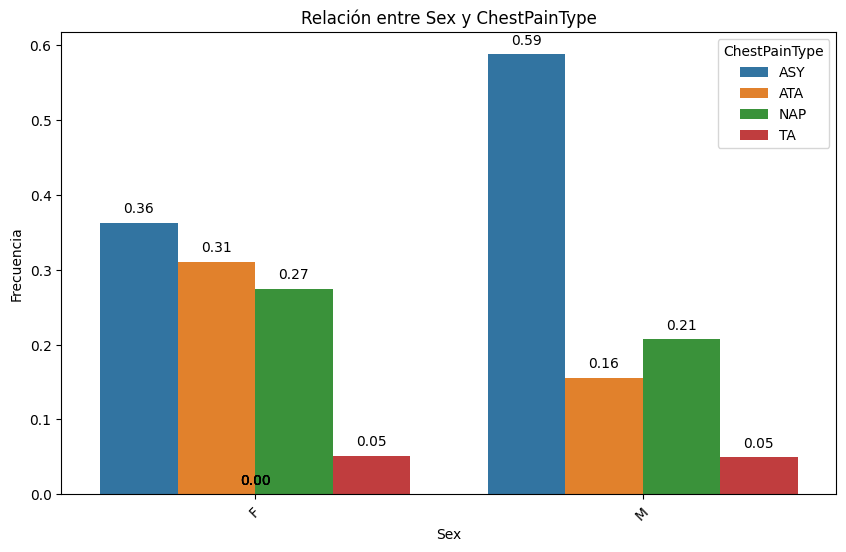

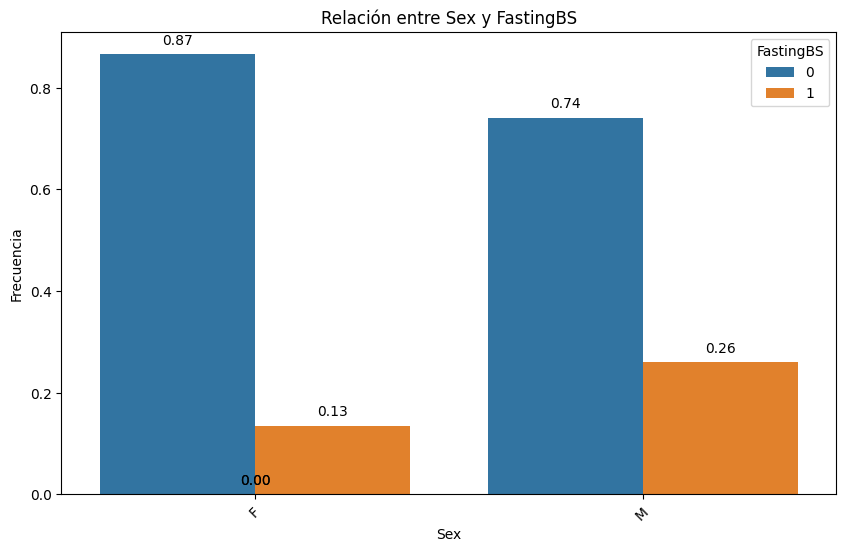

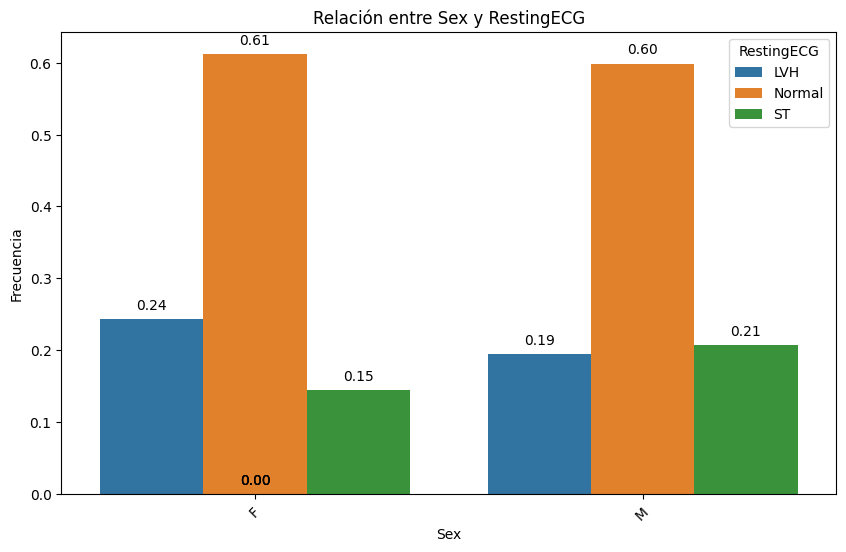

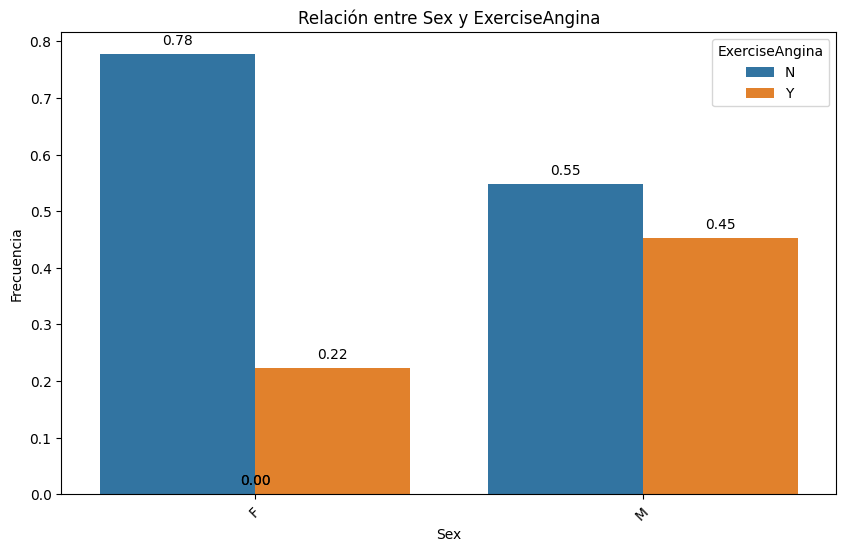

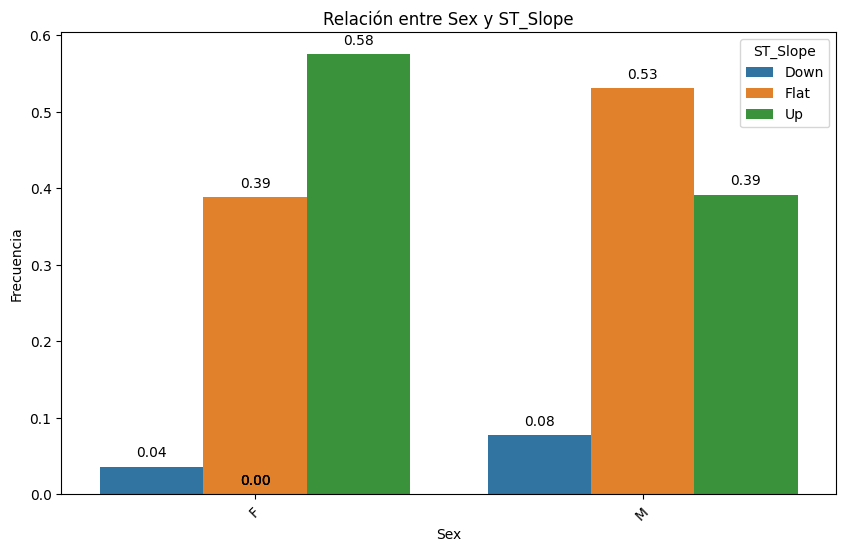

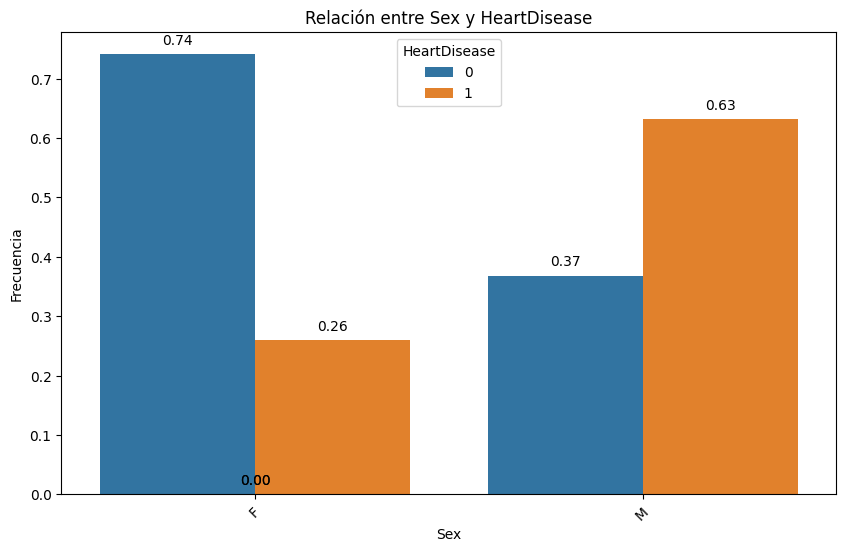

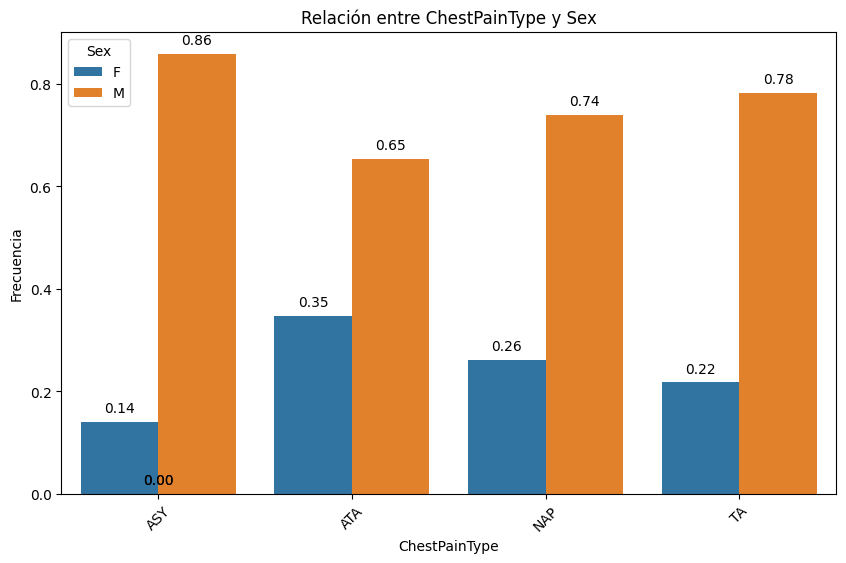

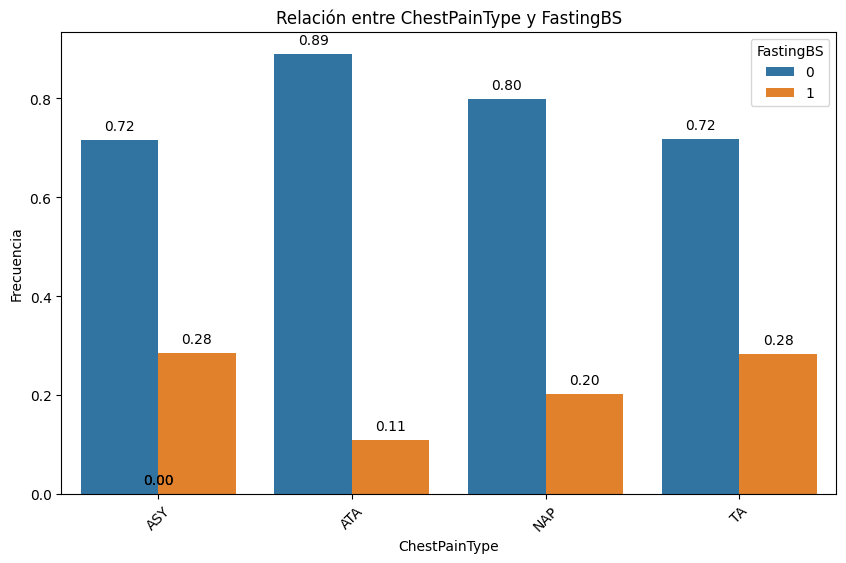

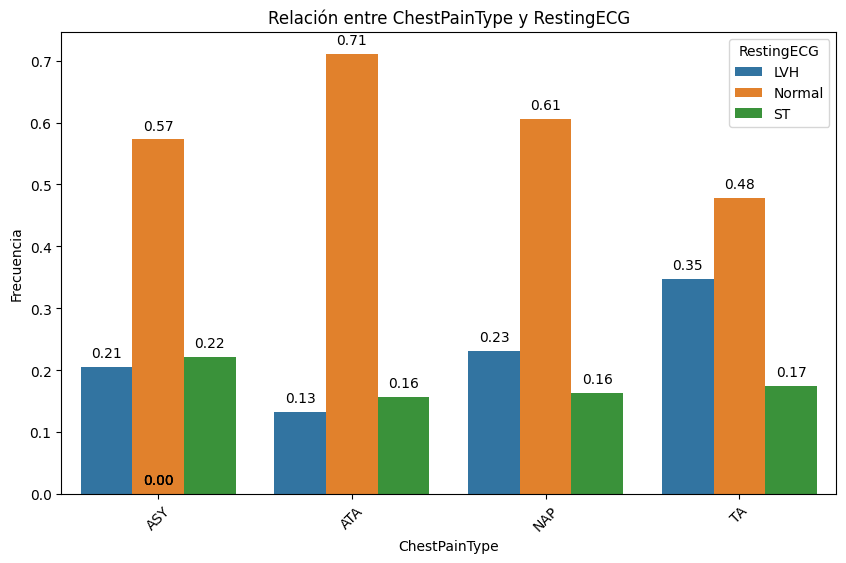

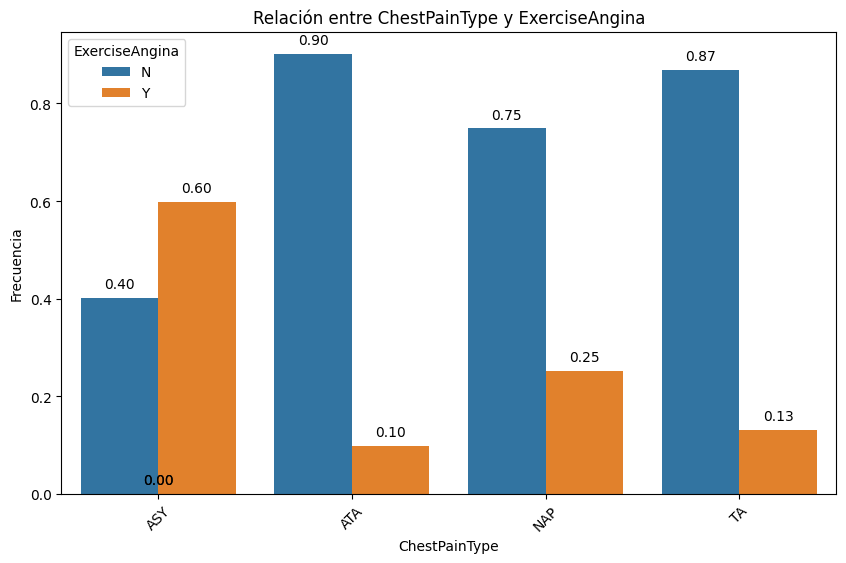

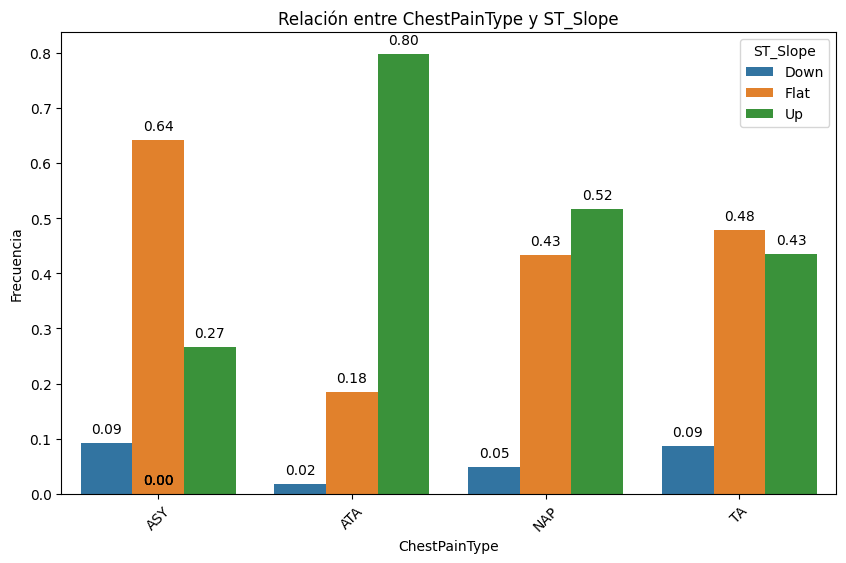

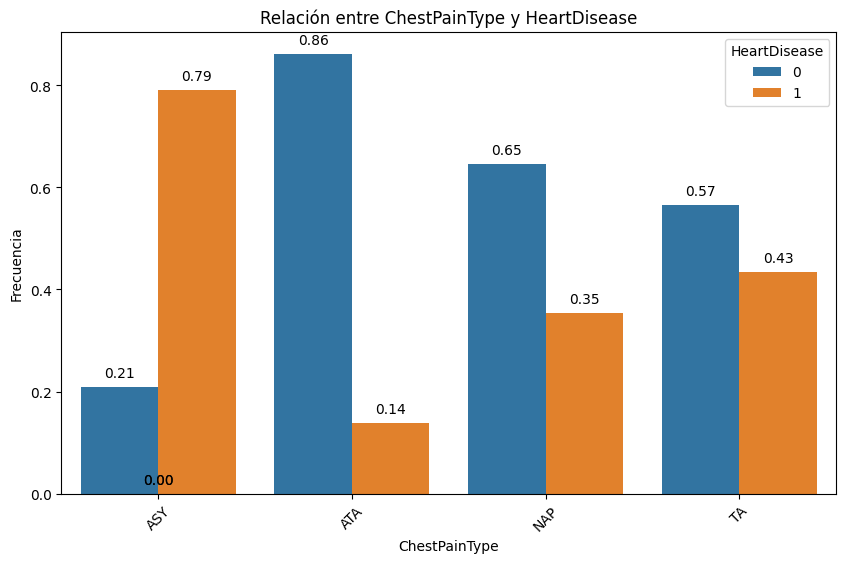

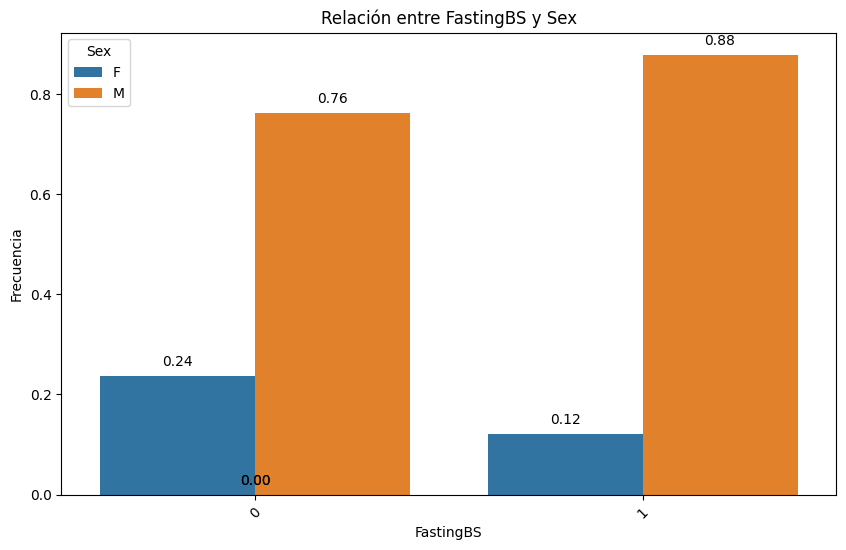

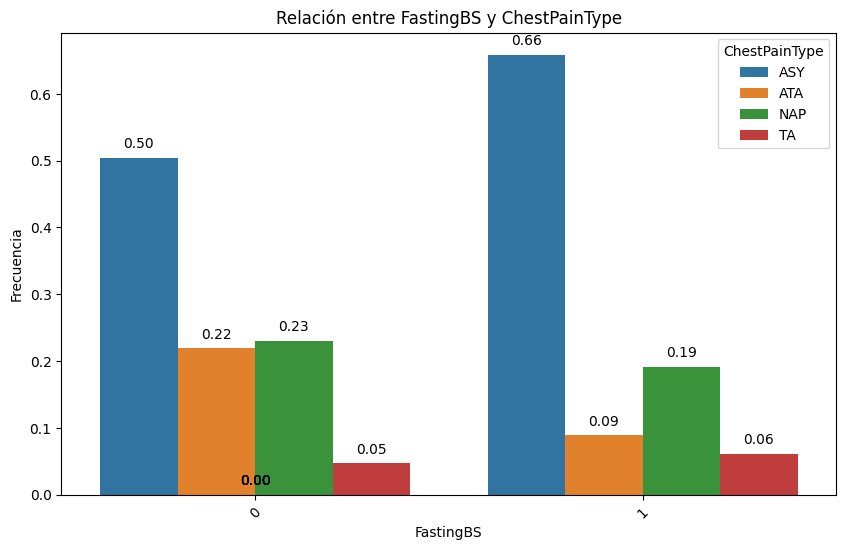

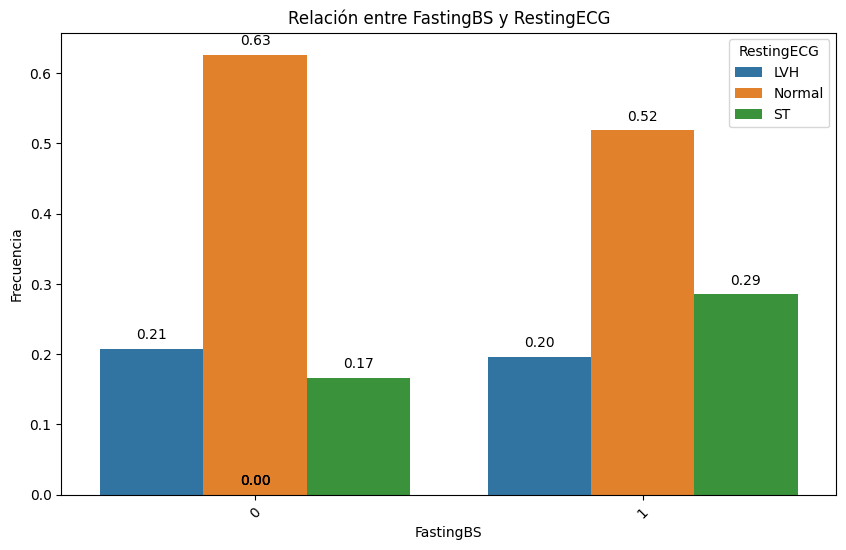

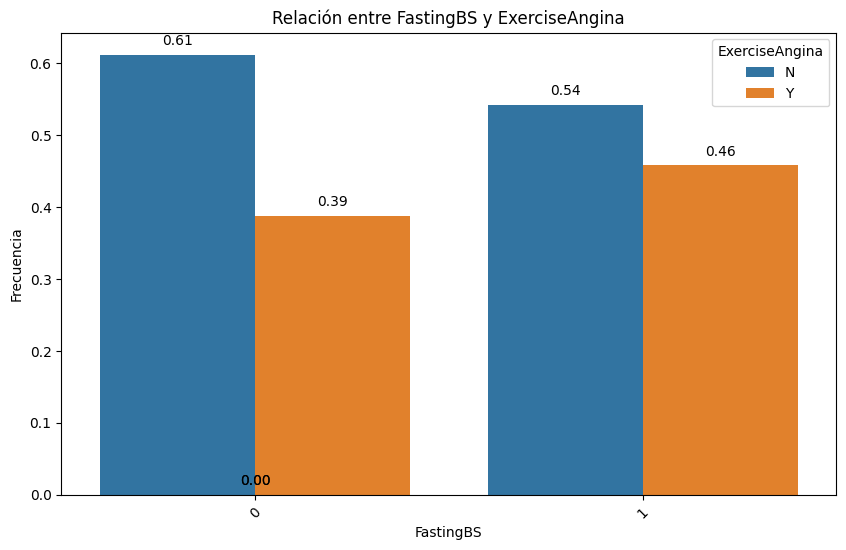

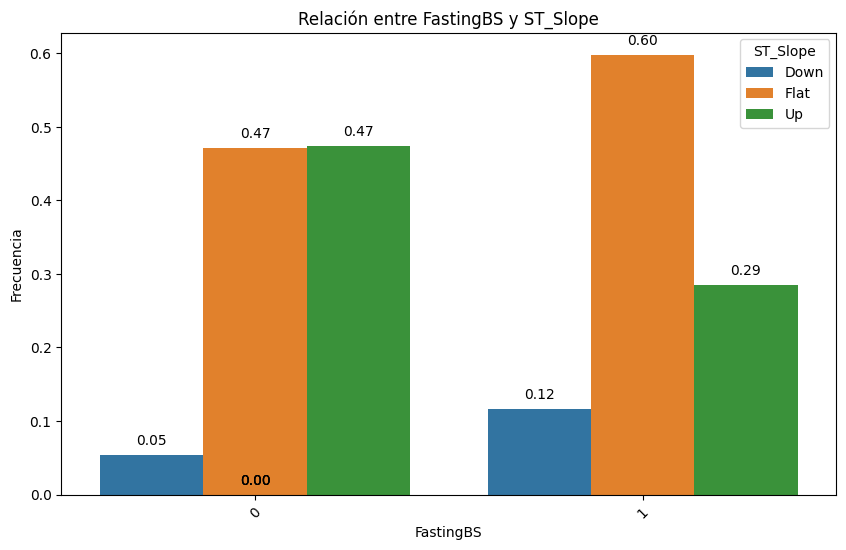

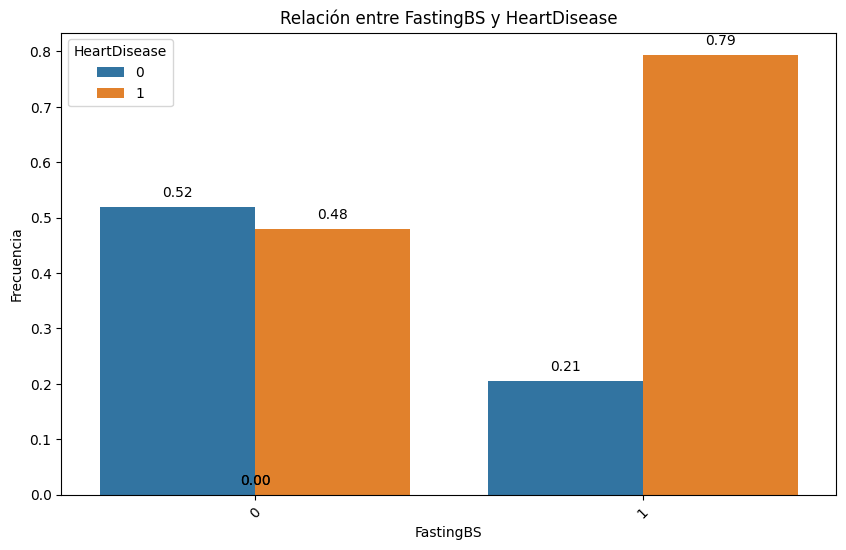

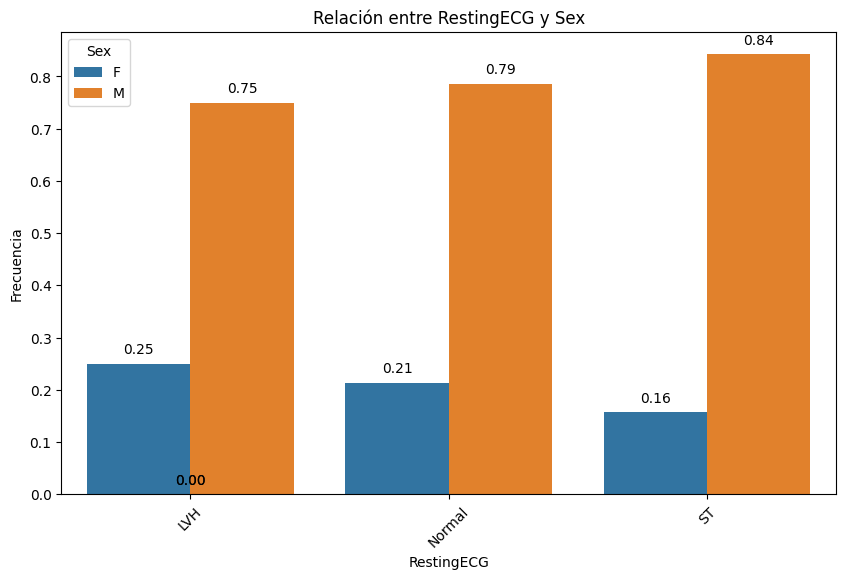

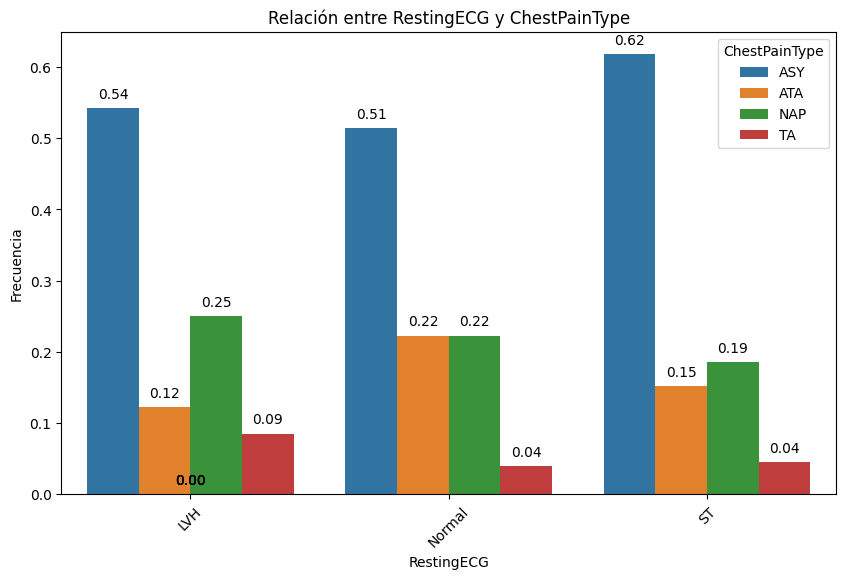

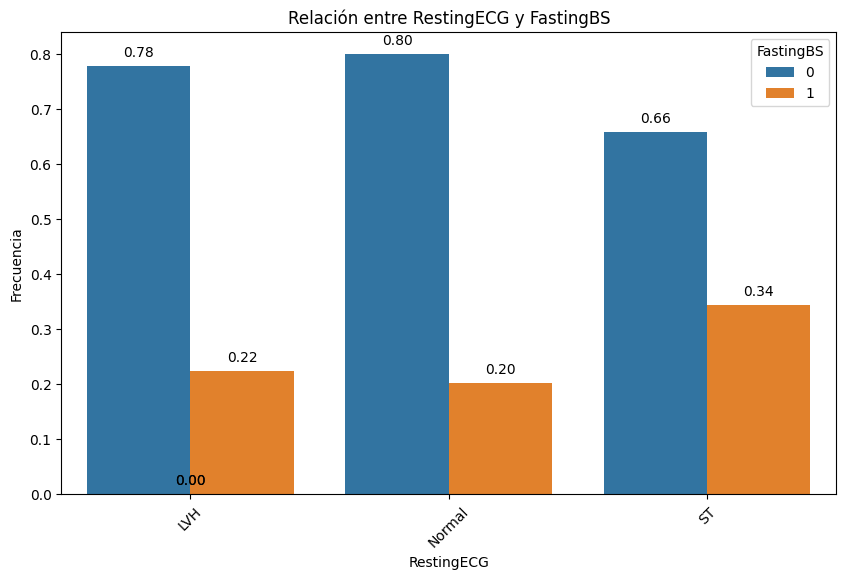

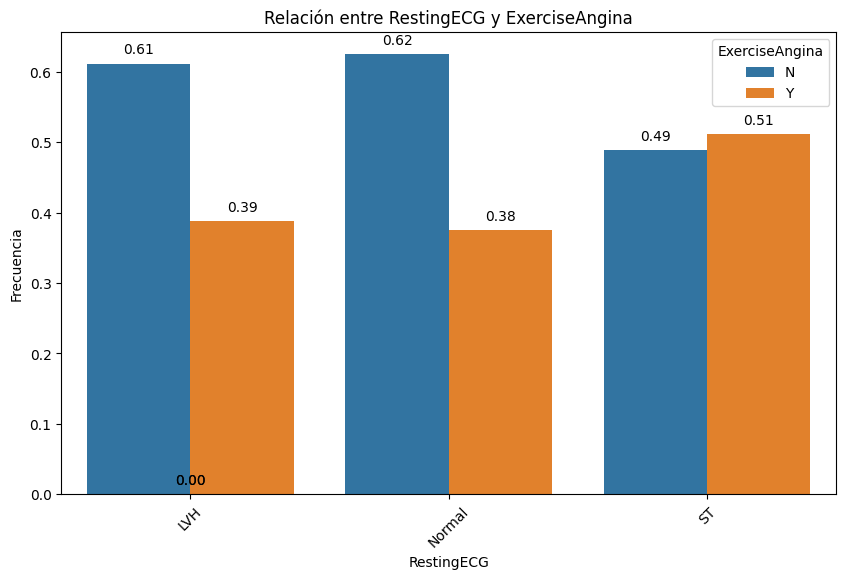

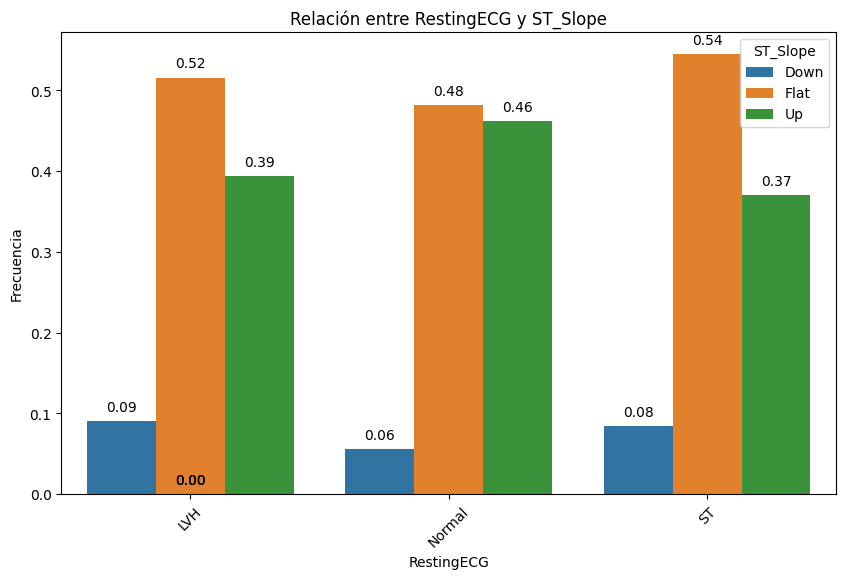

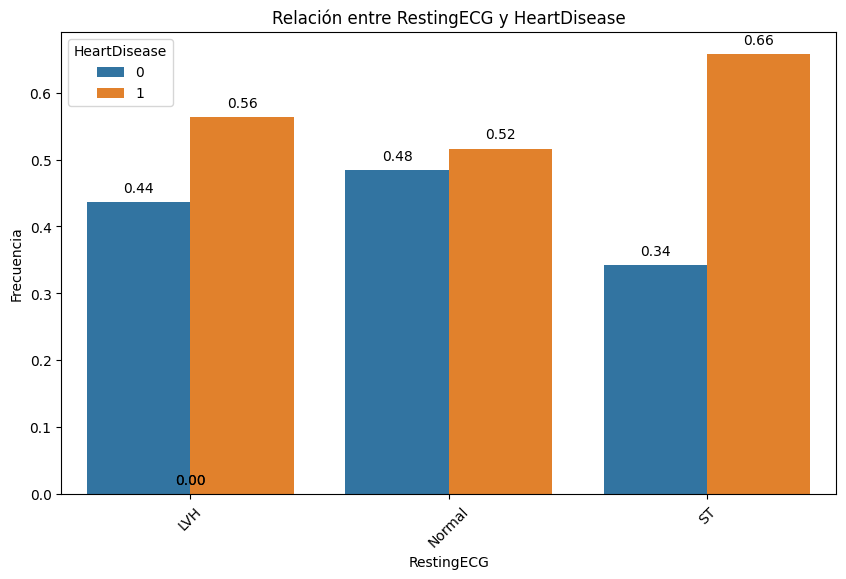

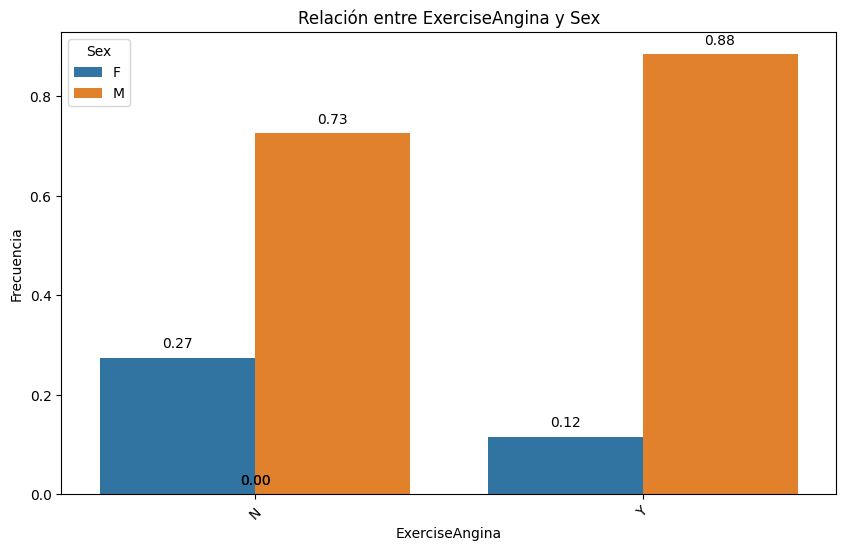

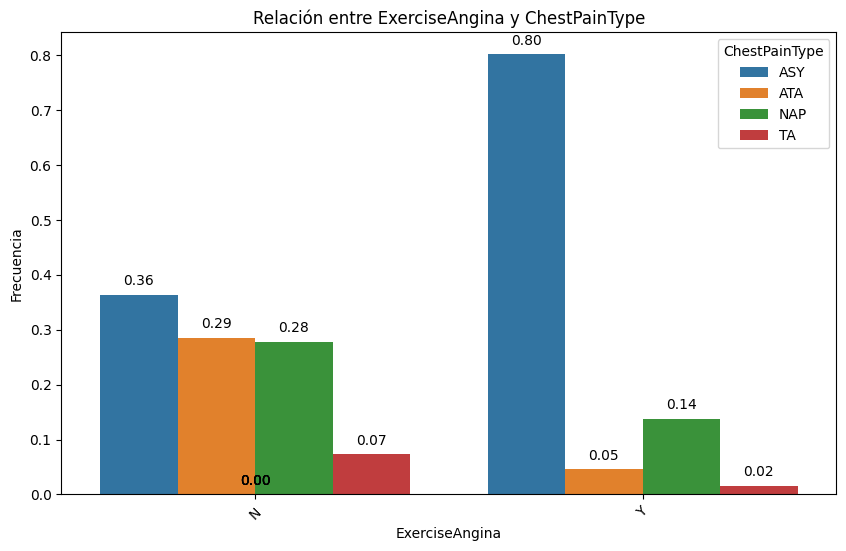

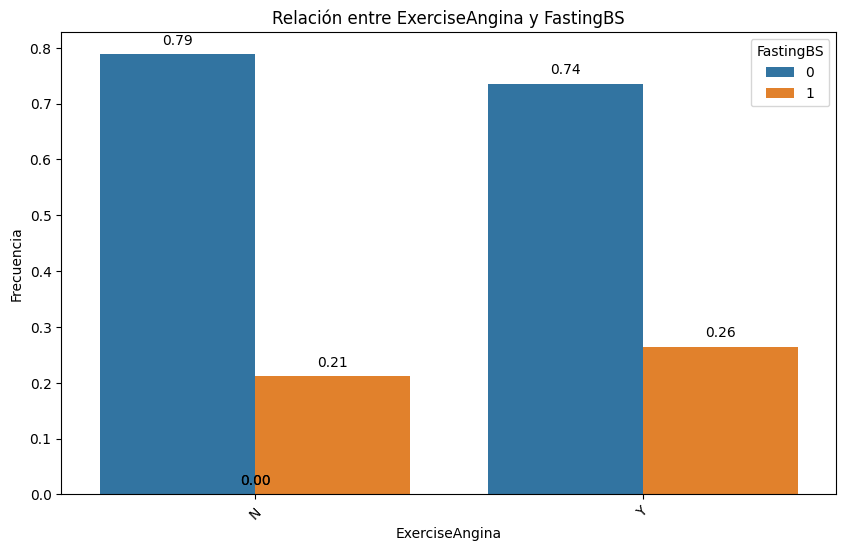

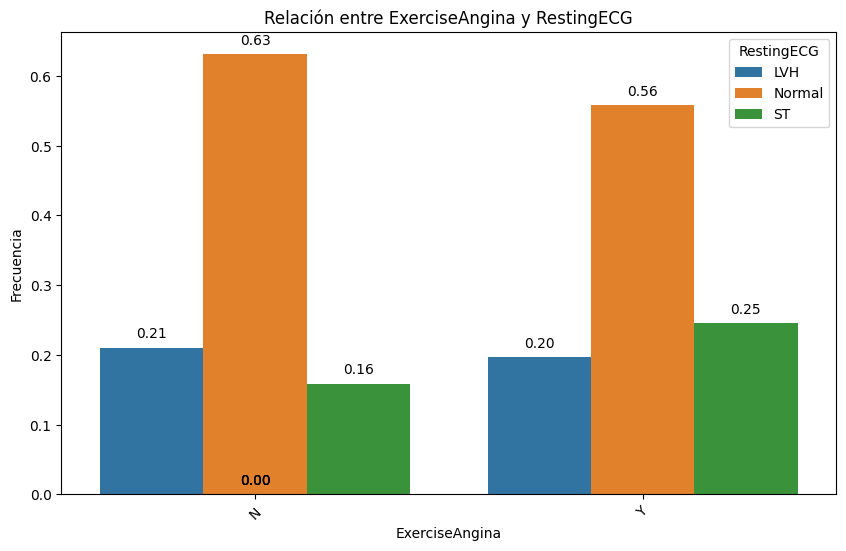

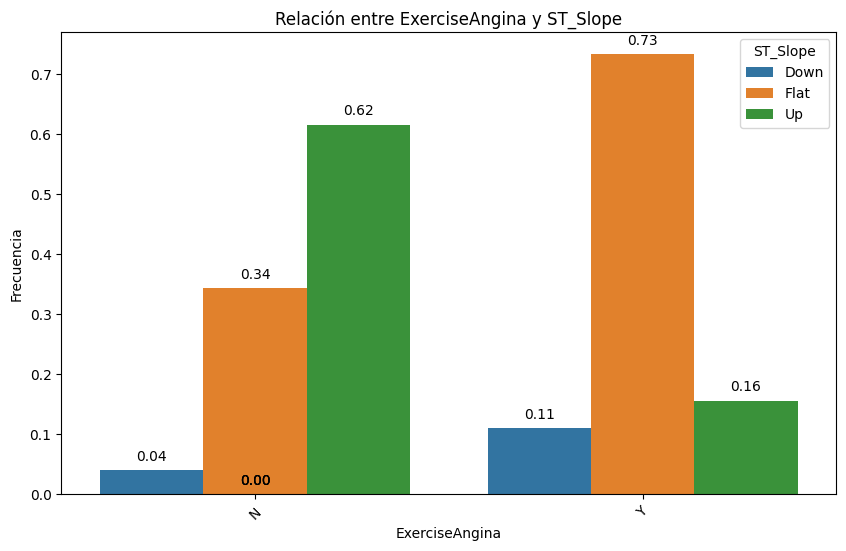

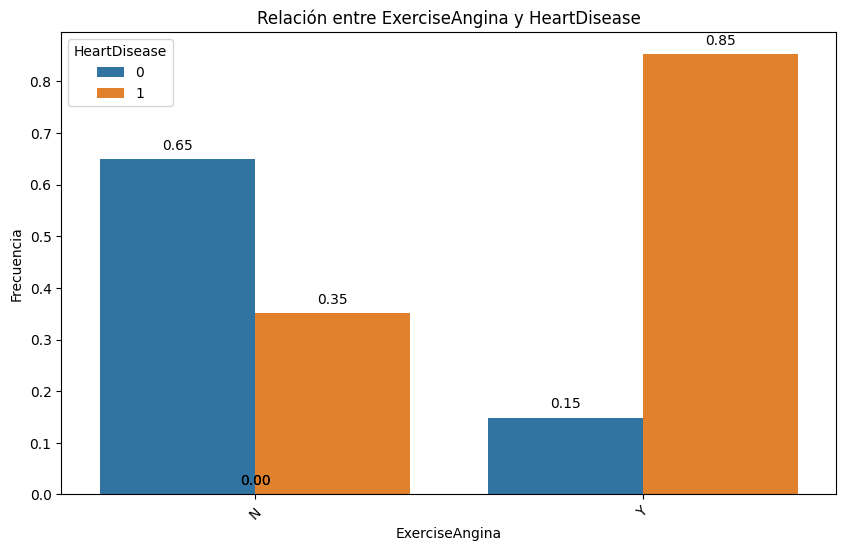

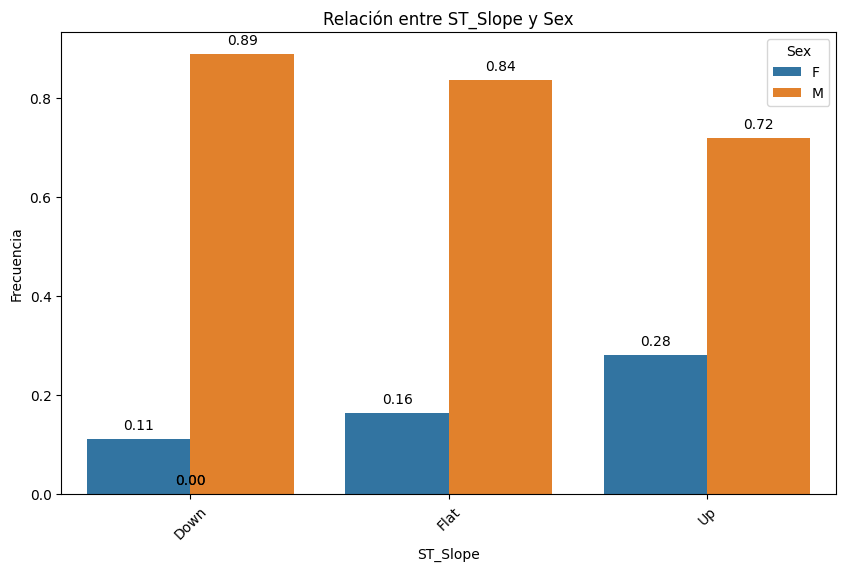

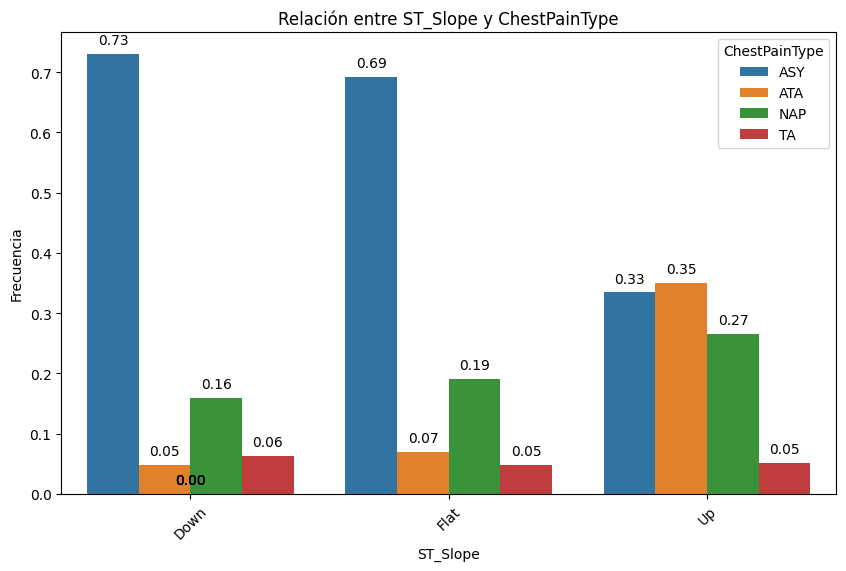

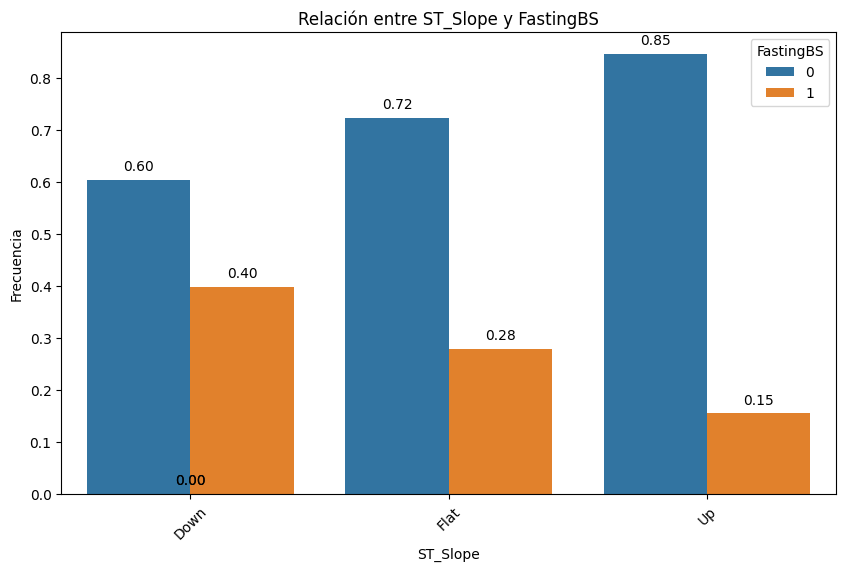

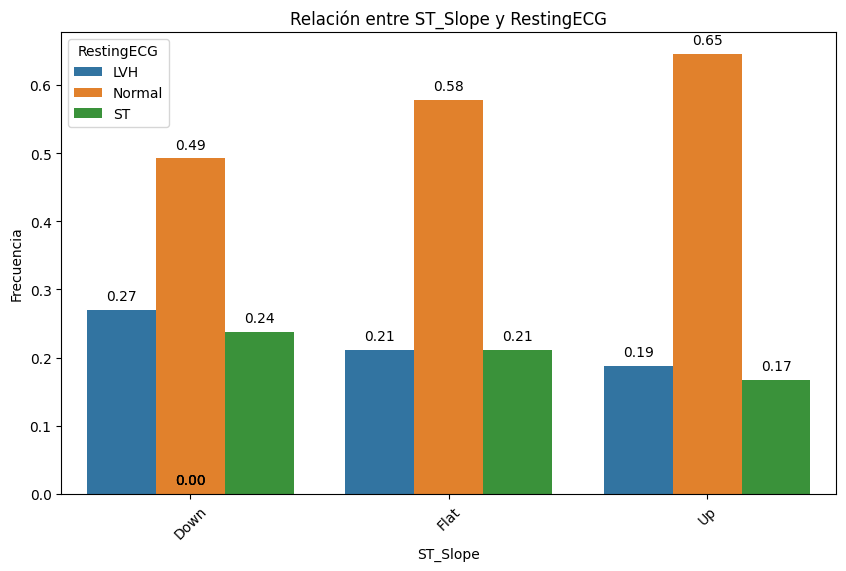

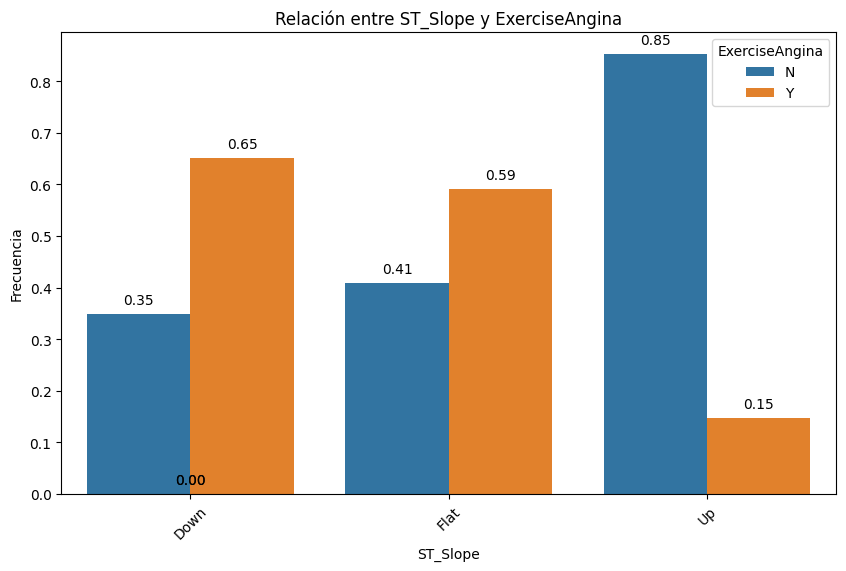

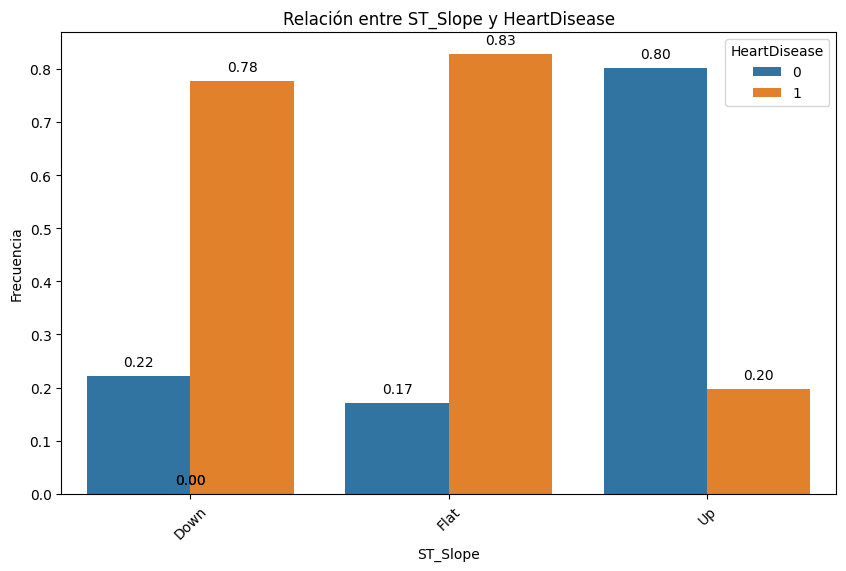

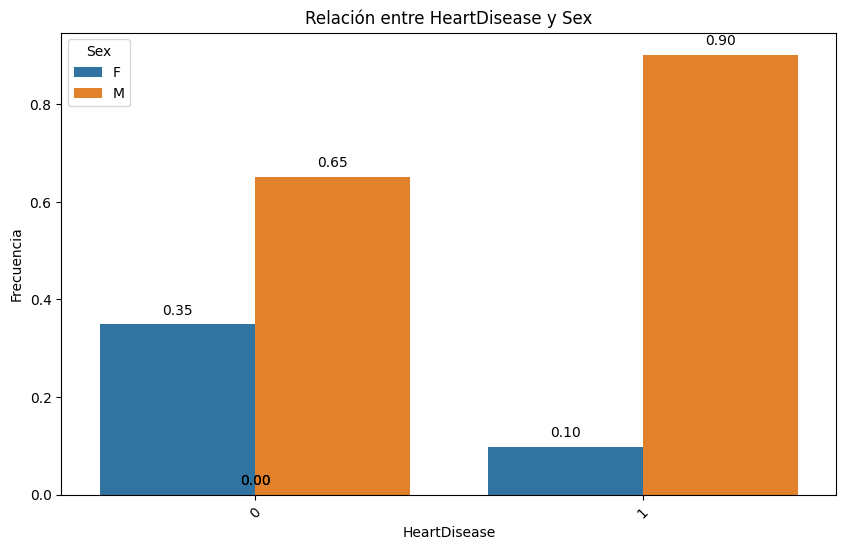

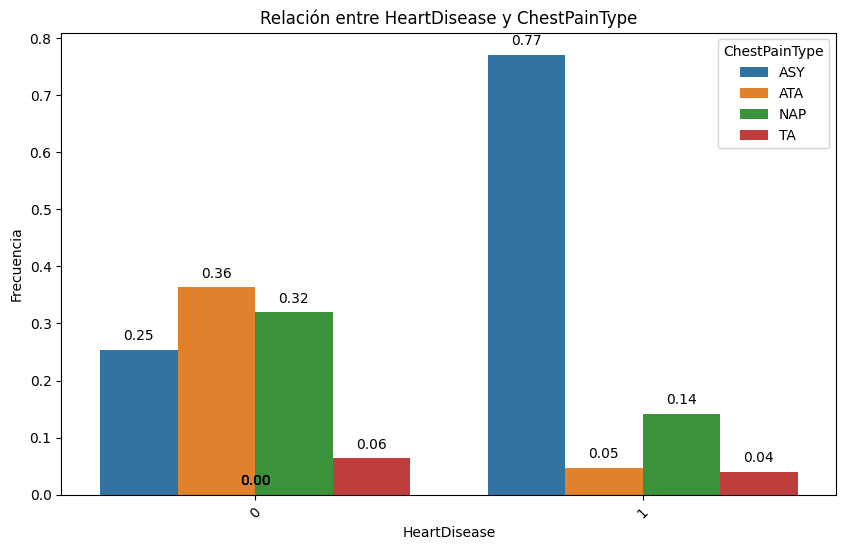

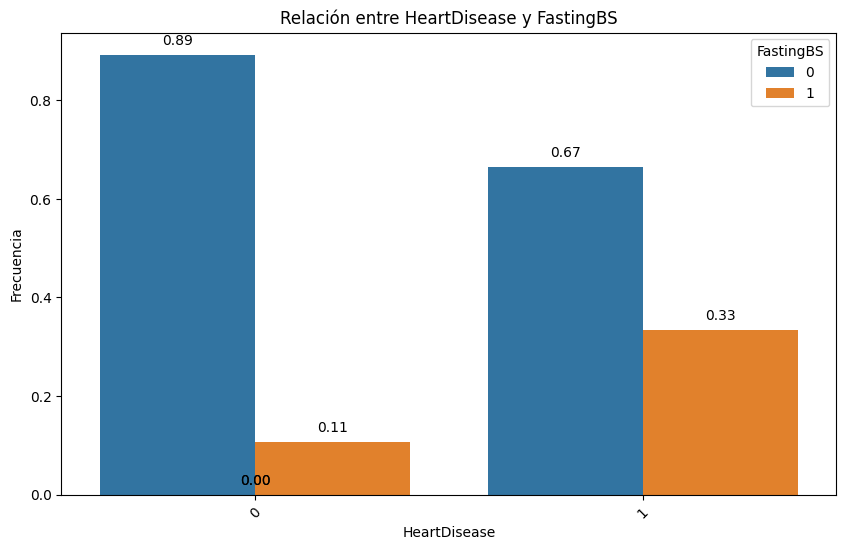

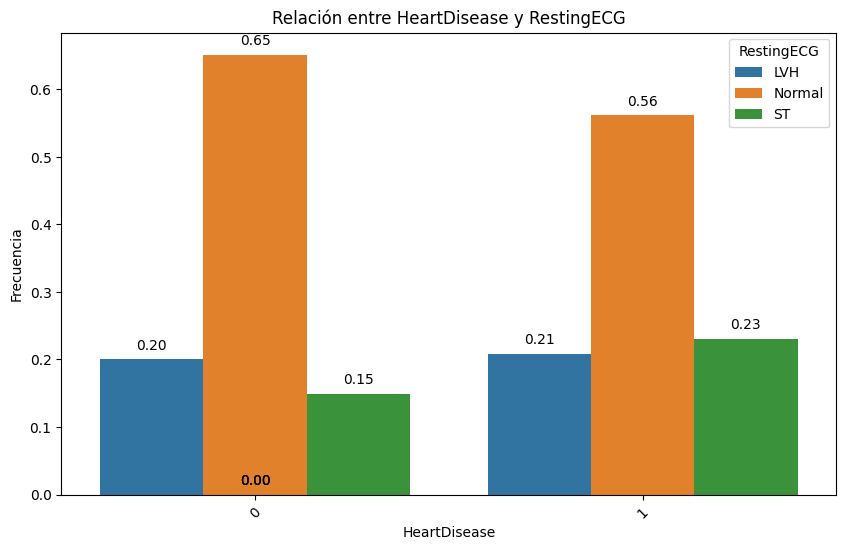

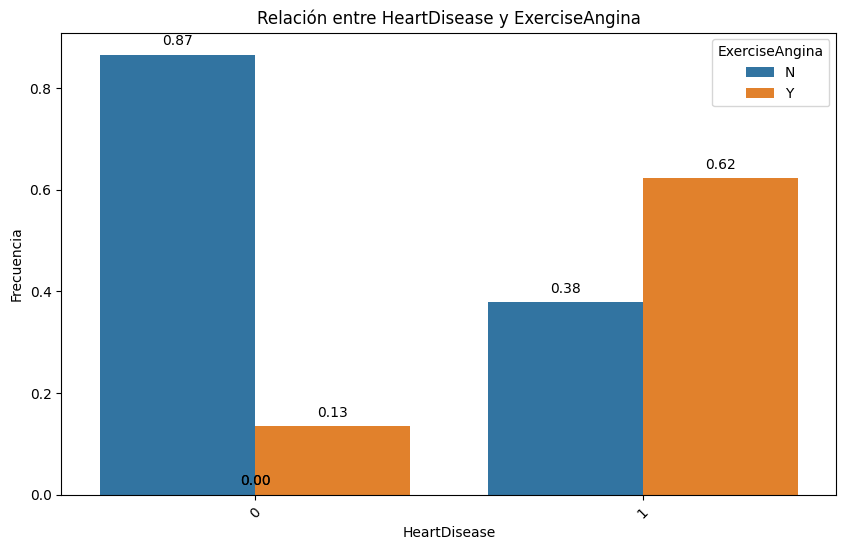

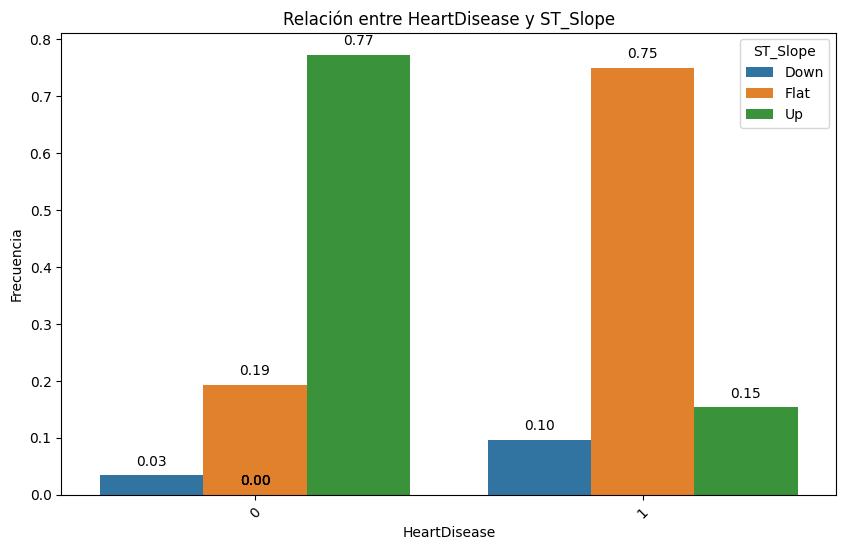

In [39]:
for columna in cols_categoricas_nominales:
    for i in range(len(cols_categoricas_nominales)):
        if columna != cols_categoricas_nominales[i]:
            plot_categorical_relationship_fin(df, columna, cols_categoricas_nominales[i], relative_freq = True, show_values = True)

### ANÁLISIS MULTIVARIANTE

#### CATEGÓRICAS

#### NUMÉRICAS

In [ ]:
corr_matrix = df.corr(numeric_only = True) # Si no lo pones y tienes variables tipo texto, fallará

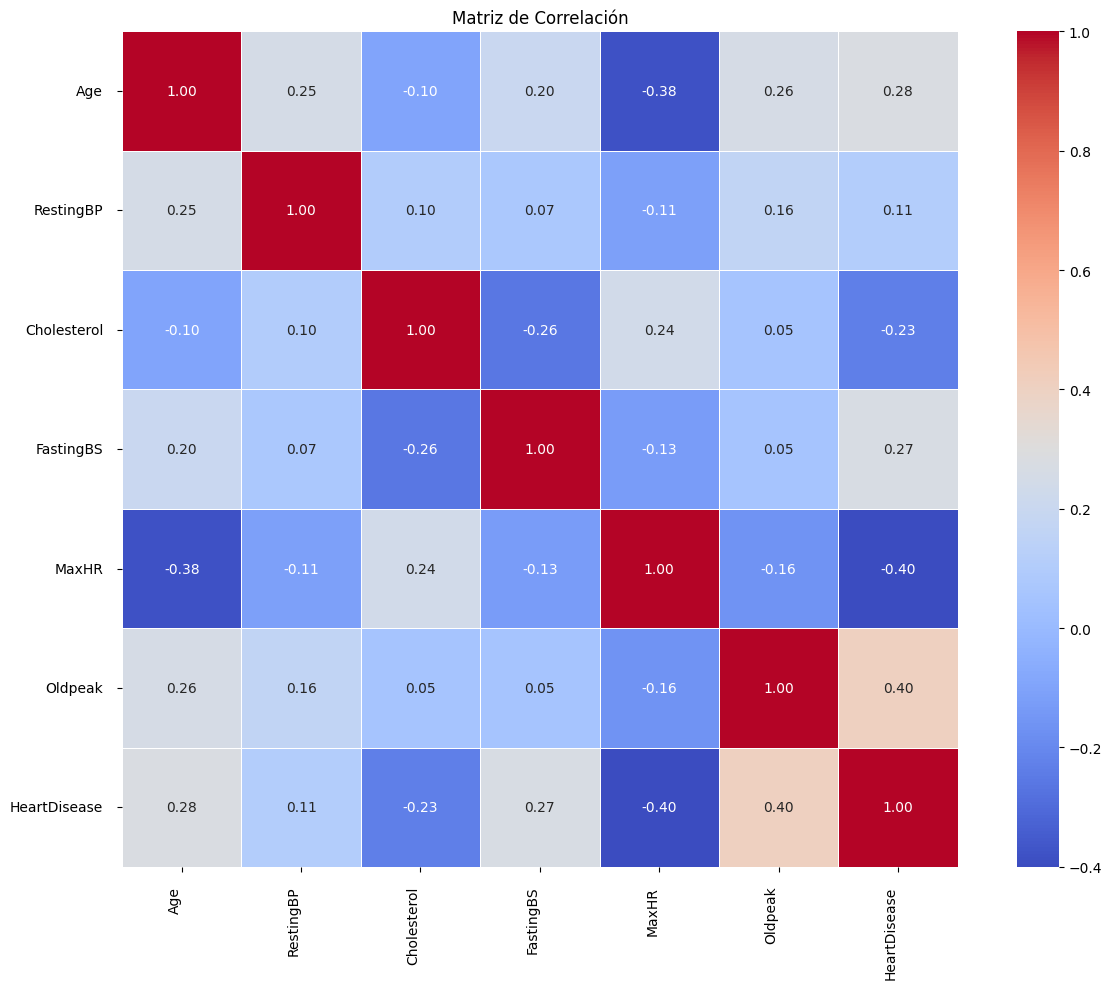

In [44]:
plt.figure(figsize=(13, 10))  # Ajusta el tamaño de la figura

# Crear el heatmap con seaborn
ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", 
                 cbar=True, square=True, linewidths=.5)

plt.title('Matriz de Correlación')

# Rotar las etiquetas de los ejes X y Y
plt.xticks(rotation=90, ha='right')  # Rotar y alinear las etiquetas de las X
plt.yticks(rotation=0, ha='right')  # Rotar y alinear las etiquetas de las Y

# Ajustar el espaciado entre las etiquetas y los ejes con `ax.tick_params()`
ax.tick_params(axis='x', which='major', pad=10)  # Añadir espacio en el eje X
ax.tick_params(axis='y', which='major', pad=10)  # Añadir espacio en el eje Y

# Ajustar automáticamente el espaciado para evitar superposición
plt.tight_layout()

plt.show()

### ANÁLISIS DE RELACIONES

#### CATEGÓRICA - CATEGÓRICA

In [106]:
for columna_i in cols_categoricas_nominales:
    for columna_j in cols_categoricas_nominales:
        if columna_i != columna_j:
            tabla_contingencia = pd.crosstab(df[columna_i], df[columna_j])
            chi2, p, dof, expected = chi2_contingency(tabla_contingencia)
            print(f"Test Chi-Cuadrado para {columna_i} - {columna_j}")
            print("Valor Chi-Cuadrado:", chi2)
            print("P-Value:", p)
            print("Grados de Libertad:", dof)
            print("--------------------")
            # print("Tabla de Frecuencias Esperadas:\n", expected)

Test Chi-Cuadrado para Sex - ChestPainType
Valor Chi-Cuadrado: 36.87917751378357
P-Value: 4.880336281360552e-08
Grados de Libertad: 3
--------------------
Test Chi-Cuadrado para Sex - FastingBS
Valor Chi-Cuadrado: 12.54817304070302
P-Value: 0.00039659385688841134
Grados de Libertad: 1
--------------------
Test Chi-Cuadrado para Sex - RestingECG
Valor Chi-Cuadrado: 4.835488217351421
P-Value: 0.08912244139807841
Grados de Libertad: 2
--------------------
Test Chi-Cuadrado para Sex - ExerciseAngina
Valor Chi-Cuadrado: 32.42516960570875
P-Value: 1.2387163558796499e-08
Grados de Libertad: 1
--------------------
Test Chi-Cuadrado para Sex - ST_Slope
Valor Chi-Cuadrado: 21.815310184744973
P-Value: 1.83174739624214e-05
Grados de Libertad: 2
--------------------
Test Chi-Cuadrado para Sex - HeartDisease
Valor Chi-Cuadrado: 84.14510134633775
P-Value: 4.597617450809164e-20
Grados de Libertad: 1
--------------------
Test Chi-Cuadrado para ChestPainType - Sex
Valor Chi-Cuadrado: 36.879177513783574
